<a href="https://colab.research.google.com/github/akashsandeepa11/model-x-dementia-risk-predictor/blob/main/dementia_predictoer_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Machine Learning - Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             precision_recall_curve, average_precision_score)

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE

# Handle imbalanced data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Model interpretation
import shap

# Utilities
from collections import Counter
import pickle
from datetime import datetime

print("✅ All libraries imported successfully!")
print(f"Timestamp: {datetime.now()}")

✅ All libraries imported successfully!
Timestamp: 2025-11-16 07:47:40.286427


In [3]:
# Load the dataset
# Replace 'your_data_file.csv' with your actual filename
df = pd.read_csv('/content/drive/MyDrive/Dementia Prediction Dataset.csv')

print("=" * 80)
print("DATASET INITIAL EXPLORATION")
print("=" * 80)

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"   - Number of rows: {df.shape[0]:,}")
print(f"   - Number of columns: {df.shape[1]:,}")

print("\n📋 First Few Rows:")
print(df.head())

print("\n📝 Column Names:")
print(df.columns.tolist())

print("\n🔍 Data Types:")
print(df.dtypes.value_counts())

print("\n💾 Memory Usage:")
print(f"{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n❓ Missing Values Summary:")
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)
print(missing_summary[missing_summary['Missing_Count'] > 0].head(20))

DATASET INITIAL EXPLORATION

📊 Dataset Shape: (195196, 1024)
   - Number of rows: 195,196
   - Number of columns: 1,024

📋 First Few Rows:
       NACCID  NACCADC PACKET  FORMVER  VISITMO  VISITDAY  VISITYR  NACCVNUM  \
0  NACC002909      186      I      3.0       12        28     2022         1   
1  NACC002909      186      F      3.0        1        23     2024         2   
2  NACC003487      186      I      3.0       11        15     2023         1   
3  NACC004352      186      I      3.0       10         5     2021         1   
4  NACC004687      186      I      3.0       11        14     2022         1   

   NACCAVST  NACCNVST  ...  NPATGAM1  NPATGAM2  NPATGAM3  NPATGAM4  NPATGAM5  \
0         2         2  ...        -4        -4        -4        -4        -4   
1         2         2  ...        -4        -4        -4        -4        -4   
2         1         1  ...        -4        -4        -4        -4        -4   
3         1         1  ...        -4        -4        -4    

🎯 IDENTIFYING TARGET VARIABLE

Potential target columns found: ['NORMCOG', 'DEMENTED', 'NACCUDSD']

✅ Target variable: DEMENTED

📊 Target Variable Distribution:
DEMENTED
0    137606
1     57590
Name: count, dtype: int64

Percentages:
DEMENTED
0    70.496322
1    29.503678
Name: proportion, dtype: float64


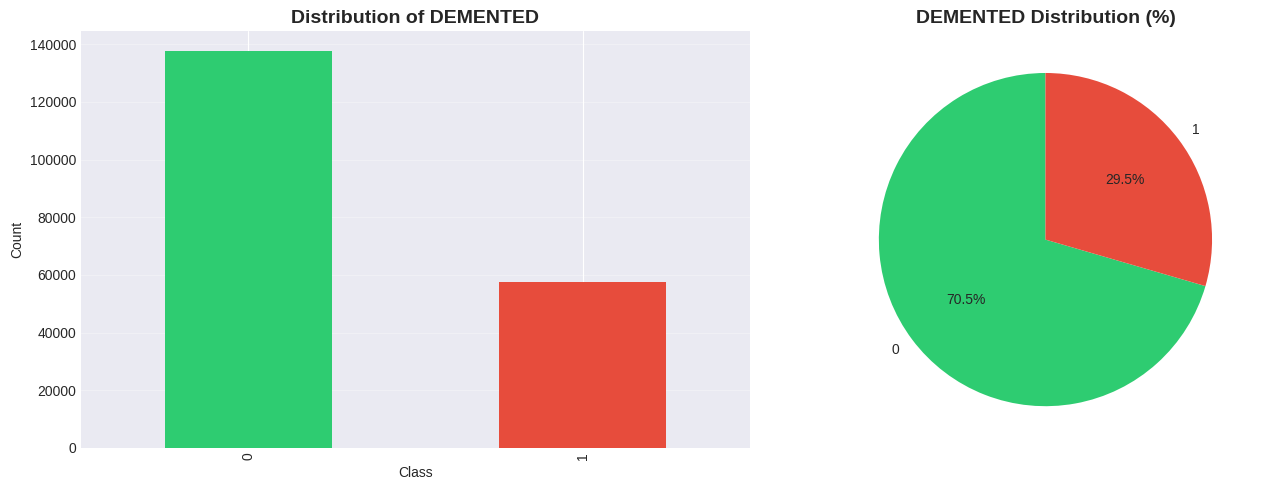


⚖️ Class Imbalance Ratio: 2.39:1
⚠️ Dataset is imbalanced. We'll handle this during modeling.


In [4]:
# Based on the dataset, the target variable should indicate dementia status
# Common names: 'DEMENTED', 'dementia', 'diagnosis', 'NACCUDSD', etc.

# Let's identify the target variable
print("🎯 IDENTIFYING TARGET VARIABLE")
print("=" * 80)

# Check for common dementia-related column names
potential_targets = [col for col in df.columns if any(keyword in col.upper()
                     for keyword in ['DEMENT', 'DIAGNOSIS', 'UDSD', 'NORMCOG'])]

print(f"\nPotential target columns found: {potential_targets}")

# Based on data dictionary, NACCUDSD is the cognitive status variable
# Let's assume the target is one of these or you specify it
TARGET_COLUMN = 'DEMENTED'  # Change this to your actual target column name

if TARGET_COLUMN in df.columns:
    print(f"\n✅ Target variable: {TARGET_COLUMN}")

    # Check target distribution
    print(f"\n📊 Target Variable Distribution:")
    print(df[TARGET_COLUMN].value_counts())
    print(f"\nPercentages:")
    print(df[TARGET_COLUMN].value_counts(normalize=True) * 100)

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Count plot
    df[TARGET_COLUMN].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
    axes[0].set_title(f'Distribution of {TARGET_COLUMN}', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)

    # Pie chart
    df[TARGET_COLUMN].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                          colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[1].set_title(f'{TARGET_COLUMN} Distribution (%)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

    # Check for class imbalance
    class_counts = df[TARGET_COLUMN].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\n⚖️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("⚠️ Dataset is imbalanced. We'll handle this during modeling.")
    else:
        print("✅ Dataset is relatively balanced.")
else:
    print(f"\n❌ Error: Column '{TARGET_COLUMN}' not found!")
    print(f"Available columns: {df.columns.tolist()[:10]}...")

In [5]:
print("🏥 DEFINING NON-MEDICAL FEATURES")
print("=" * 80)

# Based on the data dictionary and hackathon requirements,
# we'll categorize features as ALLOWED (non-medical) or EXCLUDED (medical)

# ALLOWED NON-MEDICAL FEATURES
allowed_features = {

    # Demographics (Form A1)
    'demographics': [
        'SEX',           # Subject's sex
        'HISPANIC',      # Hispanic/Latino ethnicity
        'RACE',          # Race
        'EDUC',          # Years of education - CRITICAL
        'MARISTAT',      # Marital status
        'NACCLIVS',      # Living situation
        'INDEPEND',      # Level of independence
        'RESIDENC',      # Type of residence
        'HANDED',        # Left or right handed
        'NACCAGE',       # Subject's age at visit - CRITICAL
        'BIRTHYR',       # Birth year
        'PRIMLANG',      # Primary language
    ],

    # Health History - Known conditions (Form A5)
    'health_history': [
        'TOBAC30',       # Smoked in last 30 days
        'TOBAC100',      # Smoked >100 cigarettes in life
        'SMOKYRS',       # Total years smoked
        'PACKSPER',      # Packs per day
        'QUITSMOK',      # Age when quit smoking
        'ALCOCCAS',      # Alcohol consumption (last 3 months)
        'ALCFREQ',       # Alcohol frequency
        'CVHATT',        # Heart attack/cardiac arrest
        'CVAFIB',        # Atrial fibrillation
        'CVANGIO',       # Angioplasty/endarterectomy/stent
        'CVBYPASS',      # Cardiac bypass
        'CVCHF',         # Congestive heart failure
        'CBSTROKE',      # Stroke
        'CBTIA',         # Transient ischemic attack
        'PD',            # Parkinson's disease
        'SEIZURES',      # Seizures
        'TBI',           # Traumatic brain injury
        'TBIBRIEF',      # TBI with brief loss of consciousness
        'TBIEXTEN',      # TBI with extended loss of consciousness
        'DIABETES',      # Diabetes
        'HYPERTEN',      # Hypertension
        'HYPERCHO',      # Hypercholesterolemia
        'B12DEF',        # B12 deficiency
        'THYROID',       # Thyroid disease
        'ARTHRIT',       # Arthritis
        'INCONTU',       # Urinary incontinence
        'INCONTF',       # Bowel incontinence
        'APNEA',         # Sleep apnea
        'ALCOHOL',       # Alcohol abuse
        'DEP2YRS',       # Depression in last 2 years
        'DEPOTHR',       # Depression >2 years ago
        'ANXIETY',       # Anxiety
    ],

    # Physical Measurements (Form B1) - Simple vitals people know
    'physical': [
        'HEIGHT',        # Height
        'WEIGHT',        # Weight
        'NACCBMI',       # BMI
        'BPSYS',         # Blood pressure systolic
        'BPDIAS',        # Blood pressure diastolic
        'HRATE',         # Heart rate
        'VISION',        # Vision normal
        'VISCORR',       # Uses corrective lenses
        'HEARING',       # Hearing normal
        'HEARAID',       # Uses hearing aid
    ],

    # Family History (Form A3)
    'family_history': [
        'NACCFAM',       # Family member with cognitive impairment
        'NACCMOM',       # Mother with cognitive impairment
        'NACCDAD',       # Father with cognitive impairment
    ],

    # Co-participant info (Form A2) - Social context
    'social': [
        'INRELTO',       # Co-participant relationship
        'INLIVWTH',      # Lives with co-participant
        'INVISITS',      # Frequency of in-person visits
        'INCALLS',       # Frequency of phone contact
    ],

    # Medications (Form A4) - General medication use
    'medications': [
        'NACCAMD',       # Total number of medications
        'NACCAHTN',      # Blood pressure medication
        'NACCLIPL',      # Lipid lowering medication
        'NACCNSD',       # Anti-inflammatory medication
        'NACCADEP',      # Antidepressant
    ],
}

# EXCLUDED MEDICAL/DIAGNOSTIC FEATURES
excluded_features = [
    # Cognitive test scores (C1, C2, C2T forms)
    'NACCMMSE', 'MMSEORDA', 'MMSEORLO', 'LOGIMEM', 'MEMUNITS',
    'DIGIF', 'DIGIB', 'ANIMALS', 'VEG', 'TRAILA', 'TRAILB',
    'BOSTON', 'MOCATOTS', 'NACCMOCA',

    # Clinical assessments (B forms)
    'MEMORY', 'ORIENT', 'JUDGMENT', 'COMMUN', 'HOMEHOBB', 'PERSCARE',
    'CDRSUM', 'CDRGLOB',  # CDR scores
    'NACCGDS',  # Geriatric Depression Scale
    'DEL', 'HALL', 'AGIT', 'DEPD', 'ANX',  # NPI-Q items

    # Functional assessments
    'BILLS', 'TAXES', 'SHOPPING', 'GAMES', 'STOVE', 'MEALPREP',

    # Clinical diagnoses (D1 form)
    'NACCALZD', 'NACCLBDE', 'NORMCOG', 'DEMENTED',

    # Neurological exam findings (B8 form)
    'PARKSIGN', 'CVDSIGNS', 'NORMEXAM',

    # Biomarkers and imaging
    'AMYLPET', 'FDGAD', 'HIPPATR', 'DATSCAN',

    # UPDRS scores (B3 form)
    'SPEECH', 'FACEXP', 'TRESTFAC', 'RIGDNECK',
]

# Flatten allowed features list
all_allowed_features = []
for category, features in allowed_features.items():
    all_allowed_features.extend(features)

print(f"\n✅ Total ALLOWED non-medical features: {len(all_allowed_features)}")
print(f"\n📋 Feature Categories:")
for category, features in allowed_features.items():
    print(f"   • {category.replace('_', ' ').title()}: {len(features)} features")

print(f"\n🚫 Total EXCLUDED medical/diagnostic features: {len(excluded_features)}")

# Check which allowed features are actually in the dataset
available_features = [f for f in all_allowed_features if f in df.columns]
missing_features = [f for f in all_allowed_features if f not in df.columns]

print(f"\n✅ Available in dataset: {len(available_features)}/{len(all_allowed_features)}")
print(f"❌ Missing from dataset: {len(missing_features)}")

if missing_features and len(missing_features) < 20:
    print(f"\nMissing features: {missing_features}")

🏥 DEFINING NON-MEDICAL FEATURES

✅ Total ALLOWED non-medical features: 66

📋 Feature Categories:
   • Demographics: 12 features
   • Health History: 32 features
   • Physical: 10 features
   • Family History: 3 features
   • Social: 4 features
   • Medications: 5 features

🚫 Total EXCLUDED medical/diagnostic features: 49

✅ Available in dataset: 66/66
❌ Missing from dataset: 0


In [6]:
print("🔧 CREATING WORKING DATASET")
print("=" * 80)

# Select only available non-medical features + target
features_to_use = available_features.copy()

# Create working dataframe
if TARGET_COLUMN in df.columns:
    df_work = df[features_to_use + [TARGET_COLUMN]].copy()
    print(f"\n✅ Working dataset created with {len(features_to_use)} features + target")
    print(f"   Shape: {df_work.shape}")
else:
    df_work = df[features_to_use].copy()
    print(f"\n⚠️ Target column not found. Created dataset with {len(features_to_use)} features only")
    print(f"   Shape: {df_work.shape}")

# Display basic info
print(f"\n📊 Working Dataset Info:")
print(f"   Total samples: {len(df_work):,}")
print(f"   Total features: {len(df_work.columns) - 1}")
print(f"   Memory usage: {df_work.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show sample
print(f"\n👀 Sample of working dataset:")
print(df_work.head())

# Check data types
print(f"\n📋 Data Types Distribution:")
print(df_work.dtypes.value_counts())

🔧 CREATING WORKING DATASET

✅ Working dataset created with 66 features + target
   Shape: (195196, 67)

📊 Working Dataset Info:
   Total samples: 195,196
   Total features: 66
   Memory usage: 99.78 MB

👀 Sample of working dataset:
   SEX  HISPANIC  RACE  EDUC  MARISTAT  NACCLIVS  INDEPEND  RESIDENC  HANDED  \
0    1         0     1    16         1         4         1         1       2   
1    1         0     1    16         1         2         1         1       2   
2    1         0     1    16         1         2         1         1       2   
3    2         1     1    16         1         2         2         1       2   
4    1         1     1    12         3         1         1         1       2   

   NACCAGE  ...  INRELTO  INLIVWTH  INVISITS  INCALLS  NACCAMD  NACCAHTN  \
0       70  ...        1         1         8        8       13         1   
1       71  ...        1         1         8        8       12         1   
2       66  ...        1         1         8        8      

📊 COMPREHENSIVE EXPLORATORY DATA ANALYSIS

1️⃣ MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------

📉 Features with missing values: 5
    Column  Missing_Count  Missing_Percentage
48  BPDIAS            485                0.25
45  WEIGHT            485                0.25
49   HRATE            485                0.25
47   BPSYS            485                0.25
44  HEIGHT            485                0.25


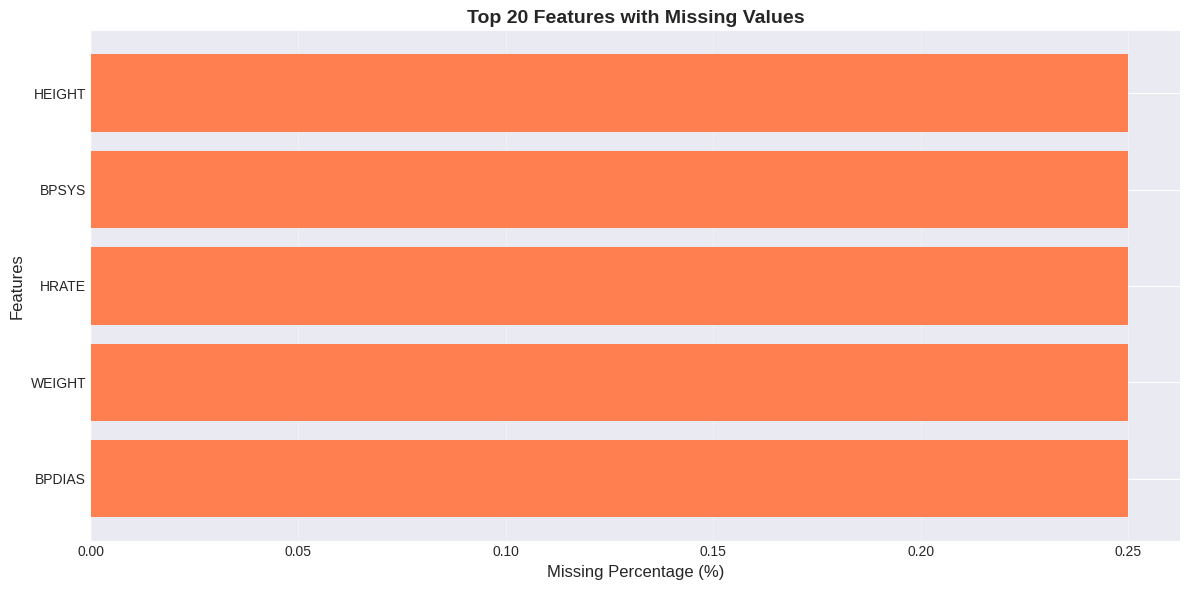


2️⃣ NUMERIC FEATURES ANALYSIS
--------------------------------------------------------------------------------
Number of numeric features: 66

📈 Basic Statistics:
                 SEX       HISPANIC           RACE           EDUC  \
count  195196.000000  195196.000000  195196.000000  195196.000000   
mean        1.580996       0.101349       2.257997      15.975163   
std         0.493397       0.583779       8.297401       6.700796   
min         1.000000       0.000000       1.000000       0.000000   
25%         1.000000       0.000000       1.000000      13.000000   
50%         2.000000       0.000000       1.000000      16.000000   
75%         2.000000       0.000000       1.000000      18.000000   
max         2.000000       9.000000      99.000000      99.000000   

            MARISTAT       NACCLIVS       INDEPEND       RESIDENC  \
count  195196.000000  195196.000000  195196.000000  195196.000000   
mean        1.777741       2.005036       1.535718       1.293008   
std    

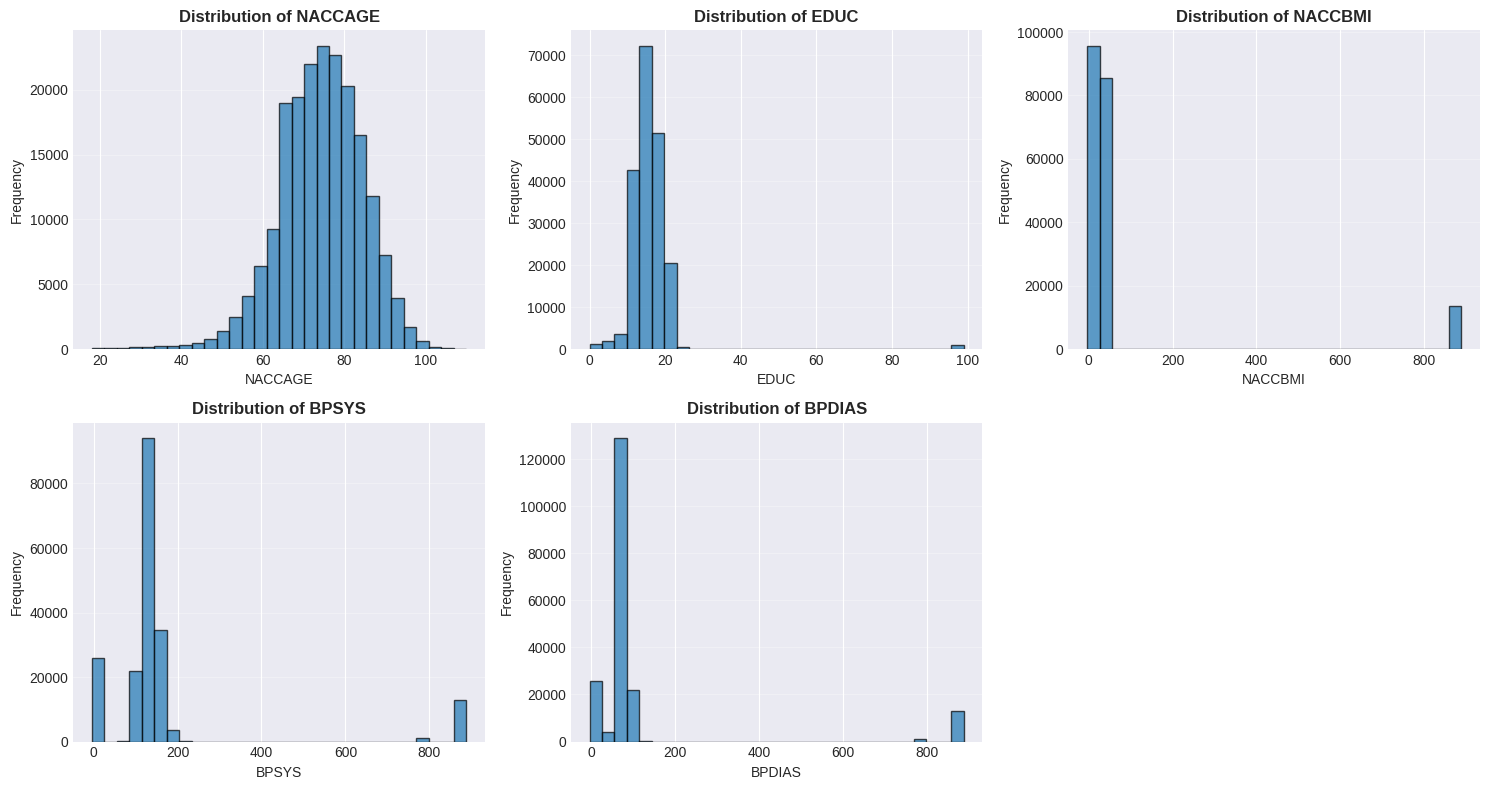


3️⃣ CATEGORICAL FEATURES ANALYSIS
--------------------------------------------------------------------------------
Number of categorical features: 0

4️⃣ CORRELATION WITH TARGET VARIABLE
--------------------------------------------------------------------------------

🎯 Top 15 features correlated with target:
INDEPEND    0.677736
NACCLIVS    0.282639
INCALLS     0.163224
NACCADEP    0.157419
DEP2YRS     0.127325
INLIVWTH    0.126932
INCONTF     0.117885
INCONTU     0.117697
RESIDENC    0.109463
CBSTROKE    0.108822
MARISTAT    0.106760
NACCDAD     0.104757
ALCOHOL     0.103942
DEPOTHR     0.103755
SEIZURES    0.101473
Name: DEMENTED, dtype: float64


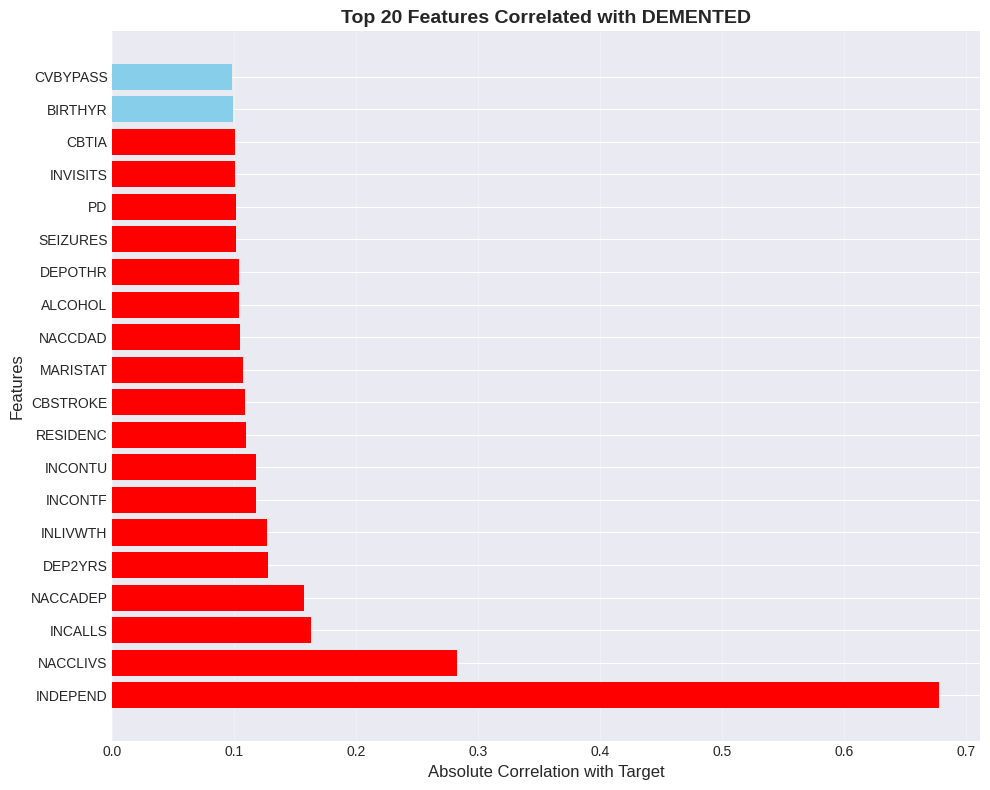


✅ EDA COMPLETED


In [7]:
print("📊 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# 1. Missing values analysis
print("\n1️⃣ MISSING VALUES ANALYSIS")
print("-" * 80)

missing_data = pd.DataFrame({
    'Column': df_work.columns,
    'Missing_Count': df_work.isnull().sum().values,
    'Missing_Percentage': (df_work.isnull().sum().values / len(df_work) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

missing_data = missing_data[missing_data['Missing_Count'] > 0]

if len(missing_data) > 0:
    print(f"\n📉 Features with missing values: {len(missing_data)}")
    print(missing_data.head(15))

    # Visualize missing values
    if len(missing_data) > 0:
        plt.figure(figsize=(12, 6))
        top_missing = missing_data.head(20)
        plt.barh(top_missing['Column'], top_missing['Missing_Percentage'], color='coral')
        plt.xlabel('Missing Percentage (%)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("✅ No missing values found!")

# 2. Numeric features analysis
print("\n2️⃣ NUMERIC FEATURES ANALYSIS")
print("-" * 80)

numeric_features = df_work.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COLUMN in numeric_features:
    numeric_features.remove(TARGET_COLUMN)

print(f"Number of numeric features: {len(numeric_features)}")

if len(numeric_features) > 0:
    print("\n📈 Basic Statistics:")
    print(df_work[numeric_features].describe())

    # Visualize distributions of key features
    key_numeric = ['NACCAGE', 'EDUC', 'NACCBMI', 'BPSYS', 'BPDIAS']
    key_numeric_available = [f for f in key_numeric if f in numeric_features]

    if len(key_numeric_available) > 0:
        n_cols = 3
        n_rows = (len(key_numeric_available) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
        axes = axes.flatten() if n_rows > 1 else [axes]

        for idx, feature in enumerate(key_numeric_available):
            if idx < len(axes):
                df_work[feature].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
                axes[idx].set_title(f'Distribution of {feature}', fontweight='bold')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Frequency')
                axes[idx].grid(axis='y', alpha=0.3)

        # Hide empty subplots
        for idx in range(len(key_numeric_available), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

# 3. Categorical features analysis
print("\n3️⃣ CATEGORICAL FEATURES ANALYSIS")
print("-" * 80)

categorical_features = df_work.select_dtypes(include=['object']).columns.tolist()
if TARGET_COLUMN in categorical_features:
    categorical_features.remove(TARGET_COLUMN)

print(f"Number of categorical features: {len(categorical_features)}")

if len(categorical_features) > 0:
    print(f"\nCategorical features: {categorical_features[:10]}...")

    # Show unique values for each categorical feature
    print("\n📊 Unique Values Count:")
    for feature in categorical_features[:10]:
        unique_count = df_work[feature].nunique()
        print(f"   {feature}: {unique_count} unique values")

# 4. Target variable correlation (for numeric features)
if TARGET_COLUMN in df_work.columns and len(numeric_features) > 0:
    print("\n4️⃣ CORRELATION WITH TARGET VARIABLE")
    print("-" * 80)

    # Calculate correlations
    correlations = df_work[numeric_features + [TARGET_COLUMN]].corr()[TARGET_COLUMN].drop(TARGET_COLUMN)
    correlations = correlations.abs().sort_values(ascending=False)

    print("\n🎯 Top 15 features correlated with target:")
    print(correlations.head(15))

    # Visualize top correlations
    plt.figure(figsize=(10, 8))
    top_corr = correlations.head(20)
    colors = ['red' if x > 0.1 else 'skyblue' for x in top_corr.values]
    plt.barh(range(len(top_corr)), top_corr.values, color=colors)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Absolute Correlation with Target', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Top 20 Features Correlated with {TARGET_COLUMN}',
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("✅ EDA COMPLETED")
print("=" * 80)

In [8]:
print("🔨 FEATURE ENGINEERING - PART 1")
print("=" * 80)

# Create a copy for feature engineering
df_engineered = df_work.copy()

print("\n1️⃣ AGE-BASED FEATURES")
print("-" * 80)

if 'NACCAGE' in df_engineered.columns:
    # Age groups
    df_engineered['age_group'] = pd.cut(df_engineered['NACCAGE'],
                                        bins=[0, 60, 70, 80, 90, 120],
                                        labels=['<60', '60-70', '70-80', '80-90', '90+'])

    # Age risk categories (dementia risk increases with age)
    df_engineered['age_risk_category'] = pd.cut(df_engineered['NACCAGE'],
                                                 bins=[0, 65, 75, 85, 120],
                                                 labels=['Low', 'Moderate', 'High', 'Very High'])

    # Age squared (non-linear relationship)
    df_engineered['age_squared'] = df_engineered['NACCAGE'] ** 2

    # Senior citizen indicator
    df_engineered['is_senior'] = (df_engineered['NACCAGE'] >= 65).astype(int)

    print(f"   ✅ Created age_group, age_risk_category, age_squared, is_senior")

print("\n2️⃣ EDUCATION-BASED FEATURES")
print("-" * 80)

if 'EDUC' in df_engineered.columns:
    # Education level categories
    df_engineered['education_level'] = pd.cut(df_engineered['EDUC'],
                                              bins=[0, 12, 16, 20, 30],
                                              labels=['High School or Less',
                                                     'Some College',
                                                     'College Grad',
                                                     'Advanced Degree'])

    # Education risk (lower education = higher risk)
    df_engineered['low_education'] = (df_engineered['EDUC'] < 12).astype(int)

    # Cognitive reserve proxy (years above minimum)
    df_engineered['cognitive_reserve'] = df_engineered['EDUC'] - 12
    df_engineered['cognitive_reserve'] = df_engineered['cognitive_reserve'].clip(lower=0)

    print(f"   ✅ Created education_level, low_education, cognitive_reserve")

print("\n3️⃣ BMI AND PHYSICAL HEALTH FEATURES")
print("-" * 80)

if 'NACCBMI' in df_engineered.columns:
    # BMI categories
    df_engineered['bmi_category'] = pd.cut(df_engineered['NACCBMI'],
                                           bins=[0, 18.5, 25, 30, 40, 100],
                                           labels=['Underweight', 'Normal',
                                                  'Overweight', 'Obese', 'Severely Obese'])

    # Unhealthy weight indicator
    df_engineered['unhealthy_weight'] = ((df_engineered['NACCBMI'] < 18.5) |
                                         (df_engineered['NACCBMI'] > 30)).astype(int)

    print(f"   ✅ Created bmi_category, unhealthy_weight")

# Calculate BMI if HEIGHT and WEIGHT available but not NACCBMI
if 'HEIGHT' in df_engineered.columns and 'WEIGHT' in df_engineered.columns:
    if 'NACCBMI' not in df_engineered.columns or df_engineered['NACCBMI'].isnull().sum() > 0:
        # BMI = weight (lbs) / (height (inches))^2 * 703
        df_engineered['calculated_bmi'] = (df_engineered['WEIGHT'] /
                                           (df_engineered['HEIGHT'] ** 2)) * 703
        print(f"   ✅ Calculated BMI from height and weight")

print("\n4️⃣ CARDIOVASCULAR HEALTH FEATURES")
print("-" * 80)

cardio_features = ['CVHATT', 'CVAFIB', 'CVCHF', 'CBSTROKE', 'CBTIA',
                  'CVANGIO', 'CVBYPASS', 'HYPERTEN', 'HYPERCHO']
available_cardio = [f for f in cardio_features if f in df_engineered.columns]

if len(available_cardio) > 0:
    # Count cardiovascular conditions
    df_engineered['cardio_condition_count'] = df_engineered[available_cardio].sum(axis=1)

    # Major cardiovascular event indicator
    major_cardio = ['CVHATT', 'CBSTROKE', 'CVCHF']
    available_major = [f for f in major_cardio if f in df_engineered.columns]
    if len(available_major) > 0:
        df_engineered['has_major_cardio_event'] = (df_engineered[available_major].sum(axis=1) > 0).astype(int)

    # Cardiovascular risk score (weighted)
    df_engineered['cardio_risk_score'] = 0
    risk_weights = {'CVHATT': 3, 'CBSTROKE': 3, 'CVCHF': 2, 'CVAFIB': 2,
                   'HYPERTEN': 1, 'HYPERCHO': 1}
    for feature, weight in risk_weights.items():
        if feature in df_engineered.columns:
            df_engineered['cardio_risk_score'] += df_engineered[feature].fillna(0) * weight

    print(f"   ✅ Created {len(available_cardio)} cardiovascular features")
    print(f"   ✅ Created cardio_condition_count, cardio_risk_score")

print("\n5️⃣ LIFESTYLE RISK FEATURES")
print("-" * 80)

# Smoking features
smoking_features = ['TOBAC30', 'TOBAC100', 'SMOKYRS', 'PACKSPER']
available_smoking = [f for f in smoking_features if f in df_engineered.columns]

if len(available_smoking) > 0:
    if 'TOBAC100' in df_engineered.columns:
        df_engineered['ever_smoked'] = df_engineered['TOBAC100']

    if 'TOBAC30' in df_engineered.columns:
        df_engineered['current_smoker'] = df_engineered['TOBAC30']

    # Pack-years calculation (if available)
    if 'SMOKYRS' in df_engineered.columns and 'PACKSPER' in df_engineered.columns:
        df_engineered['pack_years'] = (df_engineered['SMOKYRS'] *
                                       df_engineered['PACKSPER']).fillna(0)

        # Heavy smoking indicator
        df_engineered['heavy_smoker'] = (df_engineered['pack_years'] > 20).astype(int)

    print(f"   ✅ Created smoking-related features")

# Alcohol features
if 'ALCOCCAS' in df_engineered.columns:
    df_engineered['consumes_alcohol'] = df_engineered['ALCOCCAS']

if 'ALCFREQ' in df_engineered.columns:
    df_engineered['frequent_alcohol'] = (df_engineered['ALCFREQ'] >= 3).astype(int)

if 'ALCOHOL' in df_engineered.columns:
    df_engineered['alcohol_abuse'] = df_engineered['ALCOHOL']
    print(f"   ✅ Created alcohol-related features")

print("\n6️⃣ NEUROLOGICAL HISTORY FEATURES")
print("-" * 80)

neuro_features = ['TBI', 'TBIBRIEF', 'TBIEXTEN', 'SEIZURES', 'PD']
available_neuro = [f for f in neuro_features if f in df_engineered.columns]

if len(available_neuro) > 0:
    # Count neurological conditions
    df_engineered['neuro_condition_count'] = df_engineered[available_neuro].sum(axis=1)

    # Any TBI indicator
    tbi_cols = ['TBI', 'TBIBRIEF', 'TBIEXTEN']
    available_tbi = [f for f in tbi_cols if f in df_engineered.columns]
    if len(available_tbi) > 0:
        df_engineered['has_tbi'] = (df_engineered[available_tbi].sum(axis=1) > 0).astype(int)

    print(f"   ✅ Created neurological condition features")

print("\n7️⃣ METABOLIC/CHRONIC DISEASE FEATURES")
print("-" * 80)

metabolic_features = ['DIABETES', 'HYPERTEN', 'HYPERCHO', 'THYROID', 'B12DEF']
available_metabolic = [f for f in metabolic_features if f in df_engineered.columns]

if len(available_metabolic) > 0:
    # Count metabolic conditions
    df_engineered['metabolic_condition_count'] = df_engineered[available_metabolic].sum(axis=1)

    # Metabolic syndrome proxy (diabetes + hypertension + high cholesterol)
    if all(f in df_engineered.columns for f in ['DIABETES', 'HYPERTEN', 'HYPERCHO']):
        df_engineered['metabolic_syndrome_risk'] = (
            (df_engineered['DIABETES'].fillna(0) +
             df_engineered['HYPERTEN'].fillna(0) +
             df_engineered['HYPERCHO'].fillna(0)) >= 2
        ).astype(int)

    print(f"   ✅ Created metabolic condition features")

print("\n" + "=" * 80)
print(f"✅ FEATURE ENGINEERING PART 1 COMPLETED")
print(f"   New shape: {df_engineered.shape}")
print("=" * 80)

🔨 FEATURE ENGINEERING - PART 1

1️⃣ AGE-BASED FEATURES
--------------------------------------------------------------------------------
   ✅ Created age_group, age_risk_category, age_squared, is_senior

2️⃣ EDUCATION-BASED FEATURES
--------------------------------------------------------------------------------
   ✅ Created education_level, low_education, cognitive_reserve

3️⃣ BMI AND PHYSICAL HEALTH FEATURES
--------------------------------------------------------------------------------
   ✅ Created bmi_category, unhealthy_weight

4️⃣ CARDIOVASCULAR HEALTH FEATURES
--------------------------------------------------------------------------------
   ✅ Created 9 cardiovascular features
   ✅ Created cardio_condition_count, cardio_risk_score

5️⃣ LIFESTYLE RISK FEATURES
--------------------------------------------------------------------------------
   ✅ Created smoking-related features
   ✅ Created alcohol-related features

6️⃣ NEUROLOGICAL HISTORY FEATURES
-----------------------------

In [9]:
print("🔨 FEATURE ENGINEERING - PART 2")
print("=" * 80)

print("\n8️⃣ MENTAL HEALTH FEATURES")
print("-" * 80)

mental_health_features = ['DEP2YRS', 'DEPOTHR', 'ANXIETY']
available_mental = [f for f in mental_health_features if f in df_engineered.columns]

if len(available_mental) > 0:
    # Count mental health conditions
    df_engineered['mental_health_count'] = df_engineered[available_mental].sum(axis=1)

    # Any depression indicator
    dep_cols = ['DEP2YRS', 'DEPOTHR']
    available_dep = [f for f in dep_cols if f in df_engineered.columns]
    if len(available_dep) > 0:
        df_engineered['has_depression'] = (df_engineered[available_dep].sum(axis=1) > 0).astype(int)

    print(f"   ✅ Created mental health features")

print("\n9️⃣ SOCIAL ISOLATION AND SUPPORT FEATURES")
print("-" * 80)

# Living situation
if 'NACCLIVS' in df_engineered.columns:
    df_engineered['lives_alone'] = (df_engineered['NACCLIVS'] == 1).astype(int)

# Marital status
if 'MARISTAT' in df_engineered.columns:
    df_engineered['is_married'] = (df_engineered['MARISTAT'] == 1).astype(int)
    df_engineered['is_widowed'] = (df_engineered['MARISTAT'] == 2).astype(int)

# Independence level
if 'INDEPEND' in df_engineered.columns:
    df_engineered['fully_independent'] = (df_engineered['INDEPEND'] == 1).astype(int)

# Social support score
social_features = []
if 'INLIVWTH' in df_engineered.columns:
    social_features.append('INLIVWTH')
if 'INVISITS' in df_engineered.columns:
    social_features.append('INVISITS')

if len(social_features) > 0:
    df_engineered['social_support_score'] = df_engineered[social_features].sum(axis=1)
    print(f"   ✅ Created social support features")

print("\n🔟 FAMILY HISTORY FEATURES")
print("-" * 80)

family_features = ['NACCFAM', 'NACCMOM', 'NACCDAD']
available_family = [f for f in family_features if f in df_engineered.columns]

if len(available_family) > 0:
    # Family history indicator
    df_engineered['family_history_cognitive'] = (df_engineered[available_family].sum(axis=1) > 0).astype(int)

    # Count affected family members
    df_engineered['family_affected_count'] = df_engineered[available_family].sum(axis=1)

    print(f"   ✅ Created family history features")

print("\n1️⃣1️⃣ MEDICATION COUNT FEATURES")
print("-" * 80)

if 'NACCAMD' in df_engineered.columns:
    # Medication burden categories
    df_engineered['medication_category'] = pd.cut(df_engineered['NACCAMD'],
                                                   bins=[-1, 0, 3, 7, 15, 100],
                                                   labels=['None', 'Low', 'Moderate',
                                                          'High', 'Very High'])

    # Polypharmacy indicator (>5 medications)
    df_engineered['polypharmacy'] = (df_engineered['NACCAMD'] > 5).astype(int)

    print(f"   ✅ Created medication burden features")

print("\n1️⃣2️⃣ BLOOD PRESSURE FEATURES")
print("-" * 80)

if 'BPSYS' in df_engineered.columns and 'BPDIAS' in df_engineered.columns:
    # Blood pressure categories (based on AHA guidelines)
    df_engineered['bp_category'] = 'Normal'

    # Elevated
    mask = (df_engineered['BPSYS'].between(120, 129)) & (df_engineered['BPDIAS'] < 80)
    df_engineered.loc[mask, 'bp_category'] = 'Elevated'

    # Stage 1 Hypertension
    mask = ((df_engineered['BPSYS'].between(130, 139)) |
            (df_engineered['BPDIAS'].between(80, 89)))
    df_engineered.loc[mask, 'bp_category'] = 'Stage 1 HTN'

    # Stage 2 Hypertension
    mask = ((df_engineered['BPSYS'] >= 140) | (df_engineered['BPDIAS'] >= 90))
    df_engineered.loc[mask, 'bp_category'] = 'Stage 2 HTN'

    # Pulse pressure (predictor of cardiovascular risk)
    df_engineered['pulse_pressure'] = df_engineered['BPSYS'] - df_engineered['BPDIAS']

    # Mean arterial pressure
    df_engineered['mean_arterial_pressure'] = (df_engineered['BPDIAS'] +
                                                (df_engineered['pulse_pressure'] / 3))

    # High pulse pressure indicator (>60 mmHg)
    df_engineered['high_pulse_pressure'] = (df_engineered['pulse_pressure'] > 60).astype(int)

    print(f"   ✅ Created blood pressure features")

print("\n1️⃣3️⃣ SENSORY IMPAIRMENT FEATURES")
print("-" * 80)

sensory_features = []

if 'VISION' in df_engineered.columns:
    df_engineered['vision_impaired'] = (df_engineered['VISION'] == 0).astype(int)
    sensory_features.append('vision_impaired')

if 'HEARING' in df_engineered.columns:
    df_engineered['hearing_impaired'] = (df_engineered['HEARING'] == 0).astype(int)
    sensory_features.append('hearing_impaired')

if len(sensory_features) > 0:
    df_engineered['sensory_impairment_count'] = df_engineered[sensory_features].sum(axis=1)
    df_engineered['dual_sensory_impairment'] = (df_engineered['sensory_impairment_count'] >= 2).astype(int)
    print(f"   ✅ Created sensory impairment features")

print("\n1️⃣4️⃣ COMPOSITE RISK SCORES")
print("-" * 80)

# Overall health risk score (weighted sum of major risk factors)
risk_components = []

if 'cardio_risk_score' in df_engineered.columns:
    risk_components.append(('cardio_risk_score', 0.3))

if 'neuro_condition_count' in df_engineered.columns:
    risk_components.append(('neuro_condition_count', 0.2))

if 'metabolic_condition_count' in df_engineered.columns:
    risk_components.append(('metabolic_condition_count', 0.2))

if 'mental_health_count' in df_engineered.columns:
    risk_components.append(('mental_health_count', 0.15))

if 'family_history_cognitive' in df_engineered.columns:
    risk_components.append(('family_history_cognitive', 0.15))

if len(risk_components) > 0:
    df_engineered['composite_health_risk'] = 0
    for feature, weight in risk_components:
        df_engineered['composite_health_risk'] += df_engineered[feature].fillna(0) * weight

    print(f"   ✅ Created composite risk score from {len(risk_components)} components")

# Age-adjusted risk
if 'NACCAGE' in df_engineered.columns and 'composite_health_risk' in df_engineered.columns:
    df_engineered['age_adjusted_risk'] = (df_engineered['composite_health_risk'] *
                                          (df_engineered['NACCAGE'] / 70))

print("\n1️⃣5️⃣ INTERACTION FEATURES")
print("-" * 80)

interaction_count = 0

# Age × Education (protective effect of education may decrease with age)
if 'NACCAGE' in df_engineered.columns and 'EDUC' in df_engineered.columns:
    df_engineered['age_education_interaction'] = df_engineered['NACCAGE'] * df_engineered['EDUC']
    interaction_count += 1

# Age × Cardiovascular risk
if 'NACCAGE' in df_engineered.columns and 'cardio_risk_score' in df_engineered.columns:
    df_engineered['age_cardio_interaction'] = df_engineered['NACCAGE'] * df_engineered['cardio_risk_score']
    interaction_count += 1

# Age × BMI
if 'NACCAGE' in df_engineered.columns and 'NACCBMI' in df_engineered.columns:
    df_engineered['age_bmi_interaction'] = df_engineered['NACCAGE'] * df_engineered['NACCBMI']
    interaction_count += 1

# Education × Social support
if 'EDUC' in df_engineered.columns and 'social_support_score' in df_engineered.columns:
    df_engineered['education_social_interaction'] = df_engineered['EDUC'] * df_engineered['social_support_score']
    interaction_count += 1

print(f"   ✅ Created {interaction_count} interaction features")

print("\n" + "=" * 80)
print(f"✅ FEATURE ENGINEERING PART 2 COMPLETED")
print(f"   Final shape: {df_engineered.shape}")
print(f"   Total features created: {df_engineered.shape[1] - df_work.shape[1]}")
print("=" * 80)

🔨 FEATURE ENGINEERING - PART 2

8️⃣ MENTAL HEALTH FEATURES
--------------------------------------------------------------------------------
   ✅ Created mental health features

9️⃣ SOCIAL ISOLATION AND SUPPORT FEATURES
--------------------------------------------------------------------------------
   ✅ Created social support features

🔟 FAMILY HISTORY FEATURES
--------------------------------------------------------------------------------
   ✅ Created family history features

1️⃣1️⃣ MEDICATION COUNT FEATURES
--------------------------------------------------------------------------------
   ✅ Created medication burden features

1️⃣2️⃣ BLOOD PRESSURE FEATURES
--------------------------------------------------------------------------------
   ✅ Created blood pressure features

1️⃣3️⃣ SENSORY IMPAIRMENT FEATURES
--------------------------------------------------------------------------------
   ✅ Created sensory impairment features

1️⃣4️⃣ COMPOSITE RISK SCORES
-------------------------

In [10]:
print("🔧 HANDLING MISSING VALUES")
print("=" * 80)

# Analyze missing values in engineered dataset
missing_summary = pd.DataFrame({
    'Feature': df_engineered.columns,
    'Missing_Count': df_engineered.isnull().sum().values,
    'Missing_Percentage': (df_engineered.isnull().sum().values / len(df_engineered) * 100).round(2),
    'Data_Type': df_engineered.dtypes.values
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(f"\n📊 Features with missing values: {len(missing_summary)}/{df_engineered.shape[1]}")

if len(missing_summary) > 0:
    print(f"\n📋 Top features with missing values:")
    print(missing_summary.head(20))

    # Strategy for handling missing values
    print("\n🎯 IMPUTATION STRATEGY:")
    print("-" * 80)

    # Separate features by data type
    numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_engineered.select_dtypes(include=['object', 'category']).columns.tolist()

    if TARGET_COLUMN in numeric_cols:
        numeric_cols.remove(TARGET_COLUMN)
    if TARGET_COLUMN in categorical_cols:
        categorical_cols.remove(TARGET_COLUMN)

    # 1. Numeric features - use median imputation
    print(f"\n1️⃣ Numeric features: {len(numeric_cols)} features")
    numeric_missing = [col for col in numeric_cols if df_engineered[col].isnull().sum() > 0]

    if len(numeric_missing) > 0:
        print(f"   Features with missing values: {len(numeric_missing)}")
        print(f"   Strategy: Median imputation")

        imputer_numeric = SimpleImputer(strategy='median')
        df_engineered[numeric_missing] = imputer_numeric.fit_transform(df_engineered[numeric_missing])

        print(f"   ✅ Imputed {len(numeric_missing)} numeric features")

    # 2. Categorical features - use most frequent
    print(f"\n2️⃣ Categorical features: {len(categorical_cols)} features")
    categorical_missing = [col for col in categorical_cols if df_engineered[col].isnull().sum() > 0]

    if len(categorical_missing) > 0:
        print(f"   Features with missing values: {len(categorical_missing)}")
        print(f"   Strategy: Most frequent value imputation")

        imputer_categorical = SimpleImputer(strategy='most_frequent')
        df_engineered[categorical_missing] = imputer_categorical.fit_transform(df_engineered[categorical_missing])

        print(f"   ✅ Imputed {len(categorical_missing)} categorical features")

    # 3. Handle target variable missing values (if any)
    if TARGET_COLUMN in df_engineered.columns:
        target_missing = df_engineered[TARGET_COLUMN].isnull().sum()
        if target_missing > 0:
            print(f"\n⚠️ Target variable has {target_missing} missing values")
            print(f"   Strategy: Removing rows with missing target")
            df_engineered = df_engineered.dropna(subset=[TARGET_COLUMN])
            print(f"   ✅ Removed {target_missing} rows")

    # Verify no missing values remain
    remaining_missing = df_engineered.isnull().sum().sum()
    print(f"\n✅ Missing values after imputation: {remaining_missing}")

else:
    print("\n✅ No missing values found!")

print(f"\n📊 Final dataset shape: {df_engineered.shape}")
print("=" * 80)

🔧 HANDLING MISSING VALUES

📊 Features with missing values: 10/115

📋 Top features with missing values:
                    Feature  Missing_Count  Missing_Percentage Data_Type
74             bmi_category          39645               20.31  category
99      medication_category           2739                1.40  category
71          education_level           1190                0.61  category
44                   HEIGHT            485                0.25   float64
45                   WEIGHT            485                0.25   float64
47                    BPSYS            485                0.25   float64
49                    HRATE            485                0.25   float64
48                   BPDIAS            485                0.25   float64
102          pulse_pressure            485                0.25   float64
103  mean_arterial_pressure            485                0.25   float64

🎯 IMPUTATION STRATEGY:
----------------------------------------------------------------------

In [11]:
print("🔤 ENCODING CATEGORICAL VARIABLES")
print("=" * 80)

# Create a copy for encoding
df_encoded = df_engineered.copy()

# Identify categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET_COLUMN in categorical_cols:
    categorical_cols.remove(TARGET_COLUMN)

print(f"\n📋 Categorical features to encode: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print(f"\nCategorical features: {categorical_cols[:15]}...")

    # Separate into binary and multi-class categorical
    binary_cols = []
    multi_class_cols = []

    for col in categorical_cols:
        n_unique = df_encoded[col].nunique()
        if n_unique == 2:
            binary_cols.append(col)
        else:
            multi_class_cols.append(col)

    print(f"\n   Binary features: {len(binary_cols)}")
    print(f"   Multi-class features: {len(multi_class_cols)}")

    # 1. Label encoding for binary features
    if len(binary_cols) > 0:
        print(f"\n1️⃣ Label Encoding for binary features...")
        le = LabelEncoder()
        for col in binary_cols:
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        print(f"   ✅ Encoded {len(binary_cols)} binary features")

    # 2. One-hot encoding for multi-class features
    if len(multi_class_cols) > 0:
        print(f"\n2️⃣ One-Hot Encoding for multi-class features...")

        # Check cardinality
        high_cardinality = []
        low_cardinality = []

        for col in multi_class_cols:
            n_unique = df_encoded[col].nunique()
            if n_unique > 10:
                high_cardinality.append((col, n_unique))
            else:
                low_cardinality.append(col)

        if high_cardinality:
            print(f"\n   ⚠️ High cardinality features (>10 categories):")
            for col, n in high_cardinality[:5]:
                print(f"      {col}: {n} categories")
            print(f"   Strategy: Label encoding for high cardinality features")

            for col, _ in high_cardinality:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

        if low_cardinality:
            print(f"\n   One-hot encoding {len(low_cardinality)} low cardinality features...")
            df_encoded = pd.get_dummies(df_encoded, columns=low_cardinality, drop_first=True)
            print(f"   ✅ Created dummy variables")

    print(f"\n✅ All categorical features encoded")
    print(f"   Shape after encoding: {df_encoded.shape}")

else:
    print("\n✅ No categorical features to encode")

# Verify all features are numeric
non_numeric = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
if TARGET_COLUMN in non_numeric:
    non_numeric.remove(TARGET_COLUMN)

if len(non_numeric) > 0:
    print(f"\n⚠️ Warning: {len(non_numeric)} non-numeric features remain: {non_numeric}")
else:
    print(f"\n✅ All features are numeric")

print("=" * 80)

🔤 ENCODING CATEGORICAL VARIABLES

📋 Categorical features to encode: 6

Categorical features: ['age_group', 'age_risk_category', 'education_level', 'bmi_category', 'medication_category', 'bp_category']...

   Binary features: 0
   Multi-class features: 6

2️⃣ One-Hot Encoding for multi-class features...

   One-hot encoding 6 low cardinality features...
   ✅ Created dummy variables

✅ All categorical features encoded
   Shape after encoding: (195196, 130)

⚠️ Warning: 21 non-numeric features remain: ['age_group_60-70', 'age_group_70-80', 'age_group_80-90', 'age_group_90+', 'age_risk_category_Moderate', 'age_risk_category_High', 'age_risk_category_Very High', 'education_level_College Grad', 'education_level_High School or Less', 'education_level_Some College', 'bmi_category_Obese', 'bmi_category_Overweight', 'bmi_category_Severely Obese', 'bmi_category_Underweight', 'medication_category_Low', 'medication_category_Moderate', 'medication_category_None', 'medication_category_Very High', 'bp

🎯 FEATURE SELECTION

📊 Dataset for feature selection:
   Features (X): (195196, 129)
   Target (y): (195196,)
   Target distribution:
DEMENTED
0    137606
1     57590
Name: count, dtype: int64

⚠️ Dropping 21 non-numeric columns: ['age_group_60-70', 'age_group_70-80', 'age_group_80-90', 'age_group_90+', 'age_risk_category_Moderate', 'age_risk_category_High', 'age_risk_category_Very High', 'education_level_College Grad', 'education_level_High School or Less', 'education_level_Some College', 'bmi_category_Obese', 'bmi_category_Overweight', 'bmi_category_Severely Obese', 'bmi_category_Underweight', 'medication_category_Low', 'medication_category_Moderate', 'medication_category_None', 'medication_category_Very High', 'bp_category_Normal', 'bp_category_Stage 1 HTN', 'bp_category_Stage 2 HTN']

✅ Clean feature matrix shape: (195196, 108)

1️⃣ CORRELATION-BASED FEATURE SELECTION
--------------------------------------------------------------------------------

🔝 Top 20 features by correlation 

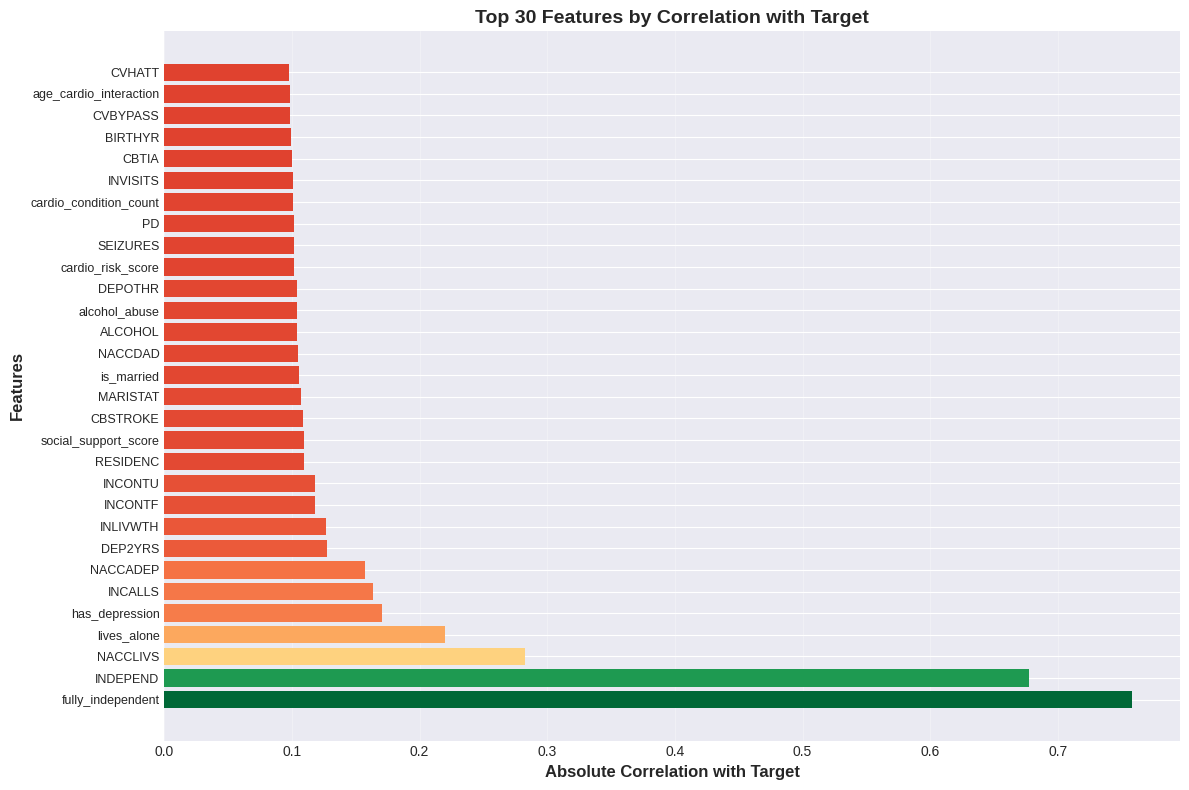


2️⃣ MUTUAL INFORMATION FEATURE SELECTION
--------------------------------------------------------------------------------
   Computing mutual information scores...

🔝 Top 20 features by mutual information:
                          Feature  MI_Score
6                        INDEPEND  0.331697
90              fully_independent  0.330515
5                        NACCLIVS  0.059691
7                        RESIDENC  0.049084
60                        INCALLS  0.043973
57                        INRELTO  0.034354
87                    lives_alone  0.032982
91           social_support_score  0.032937
59                       INVISITS  0.030641
11                       PRIMLANG  0.027870
78               consumes_alcohol  0.027825
88                     is_married  0.027293
85            mental_health_count  0.027191
98                vision_impaired  0.027118
65                       NACCADEP  0.026960
36                        ARTHRIT  0.026665
38                        INCONTF  0.026164
3

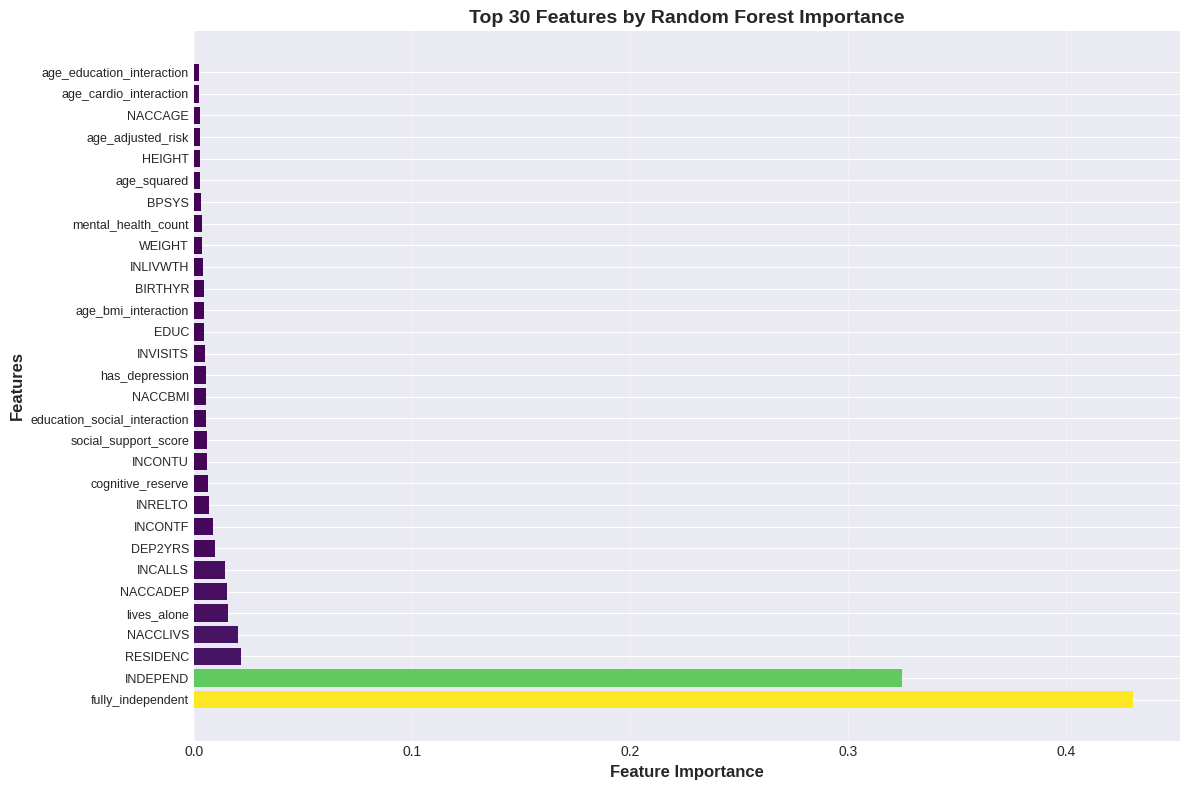


4️⃣ COMBINED FEATURE RANKING
--------------------------------------------------------------------------------

🏆 Top 30 features by combined ranking:
                   Feature  Correlation  MI_Score  RF_Importance  \
90       fully_independent     1.000000  0.996434       1.000000   
6                 INDEPEND     0.894018  1.000000       0.753966   
5                 NACCLIVS     0.370919  0.179955       0.047071   
87             lives_alone     0.287977  0.099433       0.036447   
60                 INCALLS     0.212817  0.132568       0.032690   
7                 RESIDENC     0.141639  0.147979       0.050494   
65                NACCADEP     0.205132  0.081278       0.034861   
86          has_depression     0.222609  0.048272       0.012842   
41                 DEP2YRS     0.165288  0.068887       0.022565   
38                 INCONTF     0.152789  0.078880       0.020288   
91    social_support_score     0.141433  0.099297       0.013355   
59                INVISITS     0.

In [12]:
print("🎯 FEATURE SELECTION")
print("=" * 80)

# Prepare data for feature selection
if TARGET_COLUMN in df_encoded.columns:
    X = df_encoded.drop(columns=[TARGET_COLUMN])
    y = df_encoded[TARGET_COLUMN]

    print(f"\n📊 Dataset for feature selection:")
    print(f"   Features (X): {X.shape}")
    print(f"   Target (y): {y.shape}")
    print(f"   Target distribution:\n{y.value_counts()}")

    # Handle any remaining non-numeric columns in X
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    if len(non_numeric_cols) > 0:
        print(f"\n⚠️ Dropping {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols}")
        X = X.select_dtypes(include=[np.number])

    # Replace inf values
    X = X.replace([np.inf, -np.inf], np.nan)

    # Fill any remaining NaN values
    if X.isnull().sum().sum() > 0:
        print(f"\n⚠️ Filling {X.isnull().sum().sum()} remaining NaN values with median")
        X = X.fillna(X.median())

    print(f"\n✅ Clean feature matrix shape: {X.shape}")

    # Method 1: Correlation-based feature selection
    print("\n1️⃣ CORRELATION-BASED FEATURE SELECTION")
    print("-" * 80)

    # Calculate correlation with target
    correlations = pd.DataFrame({
        'Feature': X.columns,
        'Correlation': [abs(X[col].corr(y)) for col in X.columns]
    }).sort_values('Correlation', ascending=False)

    print(f"\n🔝 Top 20 features by correlation with target:")
    print(correlations.head(20))

    # Visualize top correlations
    plt.figure(figsize=(12, 8))
    top_30_corr = correlations.head(30)
    colors = plt.cm.RdYlGn(top_30_corr['Correlation'] / top_30_corr['Correlation'].max())
    plt.barh(range(len(top_30_corr)), top_30_corr['Correlation'], color=colors)
    plt.yticks(range(len(top_30_corr)), top_30_corr['Feature'], fontsize=9)
    plt.xlabel('Absolute Correlation with Target', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 30 Features by Correlation with Target', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Method 2: Mutual Information
    print("\n2️⃣ MUTUAL INFORMATION FEATURE SELECTION")
    print("-" * 80)

    print("   Computing mutual information scores...")
    mi_scores = mutual_info_classif(X, y, random_state=42)

    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)

    print(f"\n🔝 Top 20 features by mutual information:")
    print(mi_df.head(20))

    # Method 3: Random Forest Feature Importance
    print("\n3️⃣ RANDOM FOREST FEATURE IMPORTANCE")
    print("-" * 80)

    print("   Training Random Forest for feature importance...")
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    rf_selector.fit(X, y)

    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_selector.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(f"\n🔝 Top 20 features by Random Forest importance:")
    print(importance_df.head(20))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_30_imp = importance_df.head(30)
    colors = plt.cm.viridis(top_30_imp['Importance'] / top_30_imp['Importance'].max())
    plt.barh(range(len(top_30_imp)), top_30_imp['Importance'], color=colors)
    plt.yticks(range(len(top_30_imp)), top_30_imp['Feature'], fontsize=9)
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 30 Features by Random Forest Importance', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Method 4: Combine all methods
    print("\n4️⃣ COMBINED FEATURE RANKING")
    print("-" * 80)

    # Normalize scores to 0-1 range
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()

    combined_scores = pd.DataFrame({
        'Feature': X.columns,
        'Correlation': scaler.fit_transform(correlations.set_index('Feature').loc[X.columns].values.reshape(-1, 1)).flatten(),
        'MI_Score': scaler.fit_transform(mi_df.set_index('Feature').loc[X.columns].values.reshape(-1, 1)).flatten(),
        'RF_Importance': scaler.fit_transform(importance_df.set_index('Feature').loc[X.columns].values.reshape(-1, 1)).flatten()
    })

    # Calculate combined score (average of all methods)
    combined_scores['Combined_Score'] = (
        combined_scores['Correlation'] * 0.3 +
        combined_scores['MI_Score'] * 0.3 +
        combined_scores['RF_Importance'] * 0.4
    )

    combined_scores = combined_scores.sort_values('Combined_Score', ascending=False)

    print(f"\n🏆 Top 30 features by combined ranking:")
    print(combined_scores.head(30))

    # Select top features
    n_features_to_select = min(100, len(X.columns))  # Select top 100 or all if less
    selected_features = combined_scores.head(n_features_to_select)['Feature'].tolist()

    print(f"\n✅ Selected {len(selected_features)} features for modeling")

    # Create final feature set
    X_selected = X[selected_features].copy()

    print(f"\n📊 Final feature set shape: {X_selected.shape}")

    # Save feature importance for later use
    feature_importance_dict = {
        'correlation': correlations,
        'mutual_information': mi_df,
        'random_forest': importance_df,
        'combined': combined_scores,
        'selected_features': selected_features
    }

else:
    print("❌ Target column not found!")
    X = None
    y = None
    X_selected = None

print("=" * 80)

⚖️ CLASS IMBALANCE ANALYSIS

📊 Class Distribution:
   Class   Count  Percentage
0      0  137606        70.5
1      1   57590        29.5

⚖️ Imbalance Ratio: 2.39:1


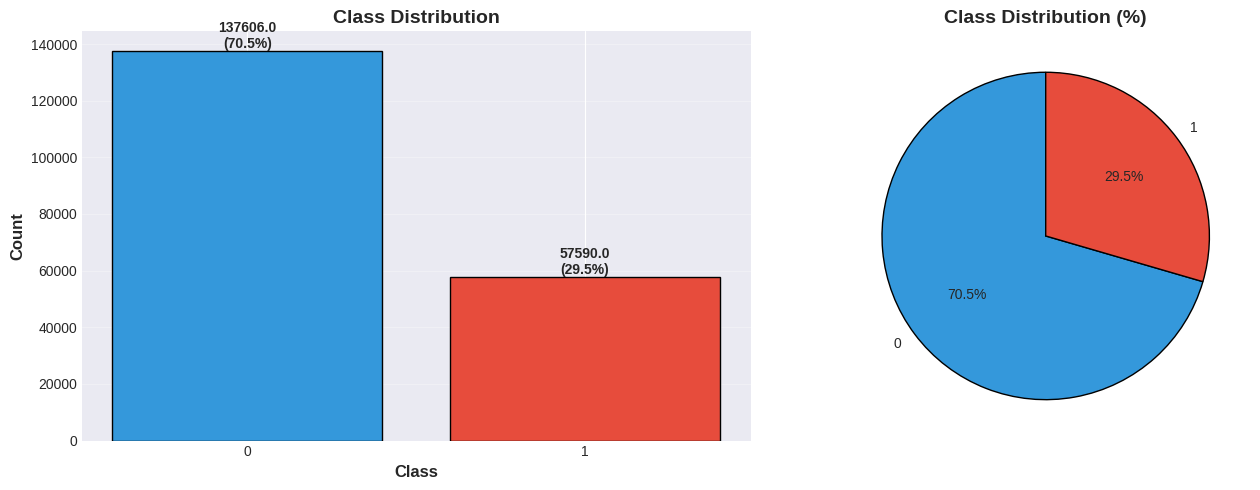


💡 RECOMMENDATION:
   ⚠️ Significant class imbalance detected (ratio: 2.39:1)
   📝 Strategies to handle:
      • Use SMOTE (Synthetic Minority Over-sampling)
      • Use class weights in models
      • Use stratified sampling
      • Ensemble methods (e.g., BalancedRandomForest)


In [13]:
print("⚖️ CLASS IMBALANCE ANALYSIS")
print("=" * 80)

if y is not None:
    # Analyze class distribution
    class_dist = pd.DataFrame({
        'Class': y.value_counts().index,
        'Count': y.value_counts().values,
        'Percentage': (y.value_counts().values / len(y) * 100).round(2)
    })

    print("\n📊 Class Distribution:")
    print(class_dist)

    # Calculate imbalance ratio
    majority_class = class_dist.iloc[0]['Count']
    minority_class = class_dist.iloc[-1]['Count']
    imbalance_ratio = majority_class / minority_class

    print(f"\n⚖️ Imbalance Ratio: {imbalance_ratio:.2f}:1")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot
    colors = ['#3498db', '#e74c3c'] if len(class_dist) == 2 else plt.cm.Set3(range(len(class_dist)))
    axes[0].bar(class_dist['Class'].astype(str), class_dist['Count'], color=colors, edgecolor='black')
    axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, (idx, row) in enumerate(class_dist.iterrows()):
        axes[0].text(i, row['Count'], f"{row['Count']}\n({row['Percentage']}%)",
                    ha='center', va='bottom', fontweight='bold')

    # Pie chart
    axes[1].pie(class_dist['Count'], labels=class_dist['Class'], autopct='%1.1f%%',
               colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
    axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Recommendation
    print("\n💡 RECOMMENDATION:")
    if imbalance_ratio > 2.0:
        print(f"   ⚠️ Significant class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
        print("   📝 Strategies to handle:")
        print("      • Use SMOTE (Synthetic Minority Over-sampling)")
        print("      • Use class weights in models")
        print("      • Use stratified sampling")
        print("      • Ensemble methods (e.g., BalancedRandomForest)")
    elif imbalance_ratio > 1.5:
        print(f"   ⚠️ Moderate class imbalance detected (ratio: {imbalance_ratio:.2f}:1)")
        print("   📝 Strategies to handle:")
        print("      • Use class weights in models")
        print("      • Use stratified sampling")
    else:
        print(f"   ✅ Classes are relatively balanced (ratio: {imbalance_ratio:.2f}:1)")
        print("   📝 No special handling required")

    # Store imbalance info
    imbalance_info = {
        'ratio': imbalance_ratio,
        'distribution': class_dist,
        'needs_handling': imbalance_ratio > 1.5
    }

else:
    print("❌ Target variable not available!")
    imbalance_info = None

print("=" * 80)

✂️ TRAIN-TEST SPLIT

📊 Splitting data:
   Test size: 20.0%
   Random state: 42
   Stratified: Yes

✅ Split completed:
   Training set: 156,156 samples (80.0%)
   Test set: 39,040 samples (20.0%)
   Number of features: 100

📊 Class distribution after split:
   Class  Train_Count  Train_Percentage  Test_Count  Test_Percentage
0      0       110084              70.5       27522             70.5
1      1        46072              29.5       11518             29.5


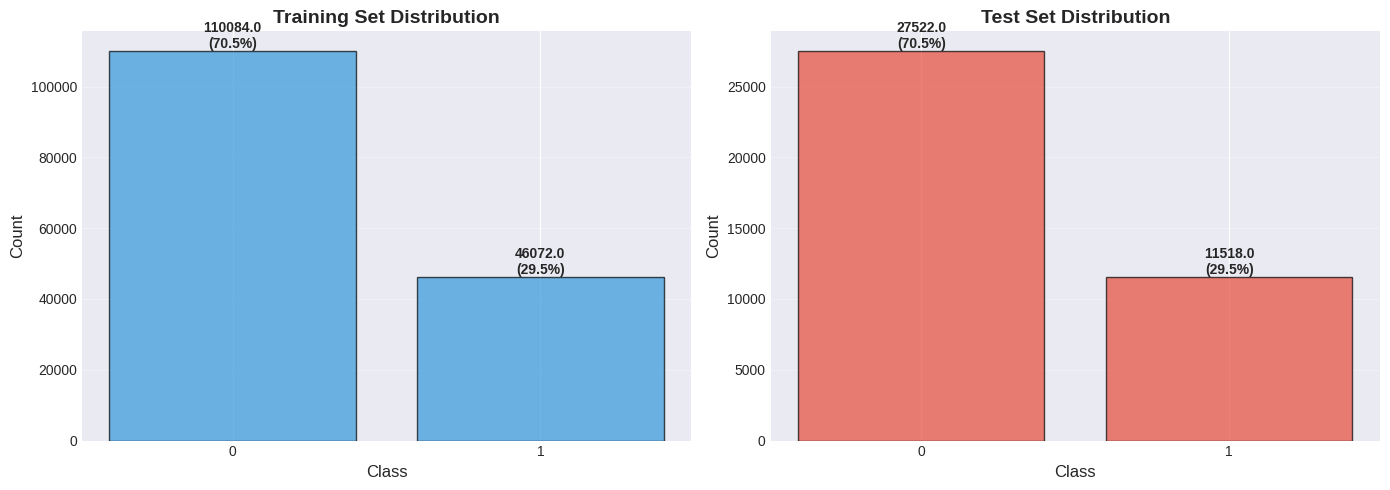


✅ Stratification maintained - distributions are similar


In [15]:
print("✂️ TRAIN-TEST SPLIT")
print("=" * 80)

if X_selected is not None and y is not None:
    # Perform stratified train-test split
    test_size = 0.2
    random_state = 42

    print(f"\n📊 Splitting data:")
    print(f"   Test size: {test_size * 100}%")
    print(f"   Random state: {random_state}")
    print(f"   Stratified: Yes")

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    print(f"\n✅ Split completed:")
    print(f"   Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_selected)*100:.1f}%)")
    print(f"   Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_selected)*100:.1f}%)")
    print(f"   Number of features: {X_train.shape[1]}")

    # Verify stratification
    print(f"\n📊 Class distribution after split:")

    train_dist = pd.DataFrame({
        'Class': y_train.value_counts().index,
        'Train_Count': y_train.value_counts().values,
        'Train_Percentage': (y_train.value_counts().values / len(y_train) * 100).round(2)
    })

    test_dist = pd.DataFrame({
        'Class': y_test.value_counts().index,
        'Test_Count': y_test.value_counts().values,
        'Test_Percentage': (y_test.value_counts().values / len(y_test) * 100).round(2)
    })

    split_comparison = train_dist.merge(test_dist, on='Class')
    print(split_comparison)

    # Visualize split
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training set
    axes[0].bar(train_dist['Class'].astype(str), train_dist['Train_Count'],
               color='#3498db', edgecolor='black', alpha=0.7)
    axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    for i, (idx, row) in enumerate(train_dist.iterrows()):
        axes[0].text(i, row['Train_Count'], f"{row['Train_Count']}\n({row['Train_Percentage']}%)",
                    ha='center', va='bottom', fontweight='bold')

    # Test set
    axes[1].bar(test_dist['Class'].astype(str), test_dist['Test_Count'],
               color='#e74c3c', edgecolor='black', alpha=0.7)
    axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Class', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)

    for i, (idx, row) in enumerate(test_dist.iterrows()):
        axes[1].text(i, row['Test_Count'], f"{row['Test_Count']}\n({row['Test_Percentage']}%)",
                    ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Stratification maintained - distributions are similar")

else:
    print("❌ Cannot perform train-test split - data not ready")
    X_train = X_test = y_train = y_test = None

print("=" * 80)

📏 FEATURE SCALING

🔧 Using RobustScaler (robust to outliers)
   Fitting scaler on training data...
   Transforming test data...

✅ Scaling completed:
   Training set scaled shape: (156156, 100)
   Test set scaled shape: (39040, 100)

📊 Example feature statistics (before vs after scaling):

Before scaling:
      fully_independent  INDEPEND  NACCLIVS
mean           0.686896  1.536528  2.006020
std            0.463758  0.965899  0.901609
min            0.000000  1.000000  1.000000
max            1.000000  9.000000  9.000000

After scaling:
      fully_independent  INDEPEND  NACCLIVS
mean          -0.313104  0.536528  0.006020
std            0.463758  0.965899  0.901609
min           -1.000000  0.000000 -1.000000
max            0.000000  8.000000  7.000000


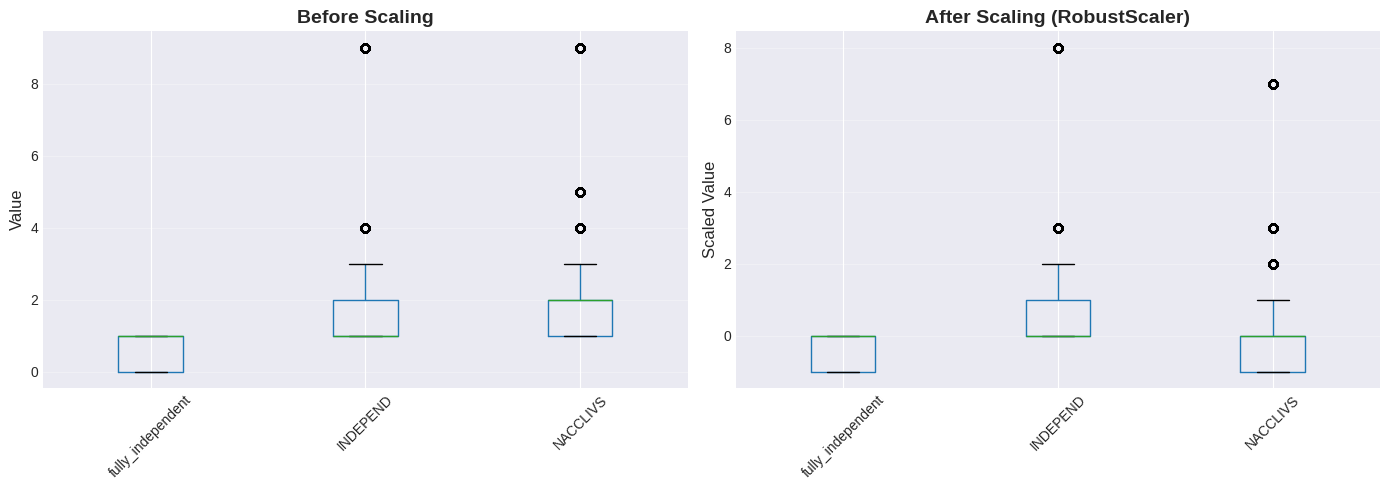


💡 Note: RobustScaler uses median and IQR, making it robust to outliers


In [16]:
print("📏 FEATURE SCALING")
print("=" * 80)

if X_train is not None and X_test is not None:
    # Use RobustScaler (less sensitive to outliers than StandardScaler)
    print("\n🔧 Using RobustScaler (robust to outliers)")

    scaler = RobustScaler()

    # Fit on training data only
    print("   Fitting scaler on training data...")
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )

    # Transform test data
    print("   Transforming test data...")
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    print(f"\n✅ Scaling completed:")
    print(f"   Training set scaled shape: {X_train_scaled.shape}")
    print(f"   Test set scaled shape: {X_test_scaled.shape}")

    # Show before/after statistics
    print(f"\n📊 Example feature statistics (before vs after scaling):")

    sample_features = X_train.columns[:3].tolist()

    before_stats = X_train[sample_features].describe().loc[['mean', 'std', 'min', 'max']]
    after_stats = X_train_scaled[sample_features].describe().loc[['mean', 'std', 'min', 'max']]

    print("\nBefore scaling:")
    print(before_stats)

    print("\nAfter scaling:")
    print(after_stats)

    # Visualize scaling effect
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Before scaling
    X_train[sample_features].boxplot(ax=axes[0])
    axes[0].set_title('Before Scaling', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Value', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # After scaling
    X_train_scaled[sample_features].boxplot(ax=axes[1])
    axes[1].set_title('After Scaling (RobustScaler)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Scaled Value', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n💡 Note: RobustScaler uses median and IQR, making it robust to outliers")

else:
    print("❌ Cannot perform scaling - train/test split not completed")
    X_train_scaled = X_test_scaled = None

print("=" * 80)

🔄 HANDLING CLASS IMBALANCE WITH SMOTE

⚖️ Class imbalance detected (ratio: 2.39:1)
   Applying SMOTE to training data...

📊 Before SMOTE:
   Training samples: 156156
DEMENTED
0    110084
1     46072
Name: count, dtype: int64

📊 After SMOTE:
   Training samples: 220168
DEMENTED
0    110084
1    110084
Name: count, dtype: int64


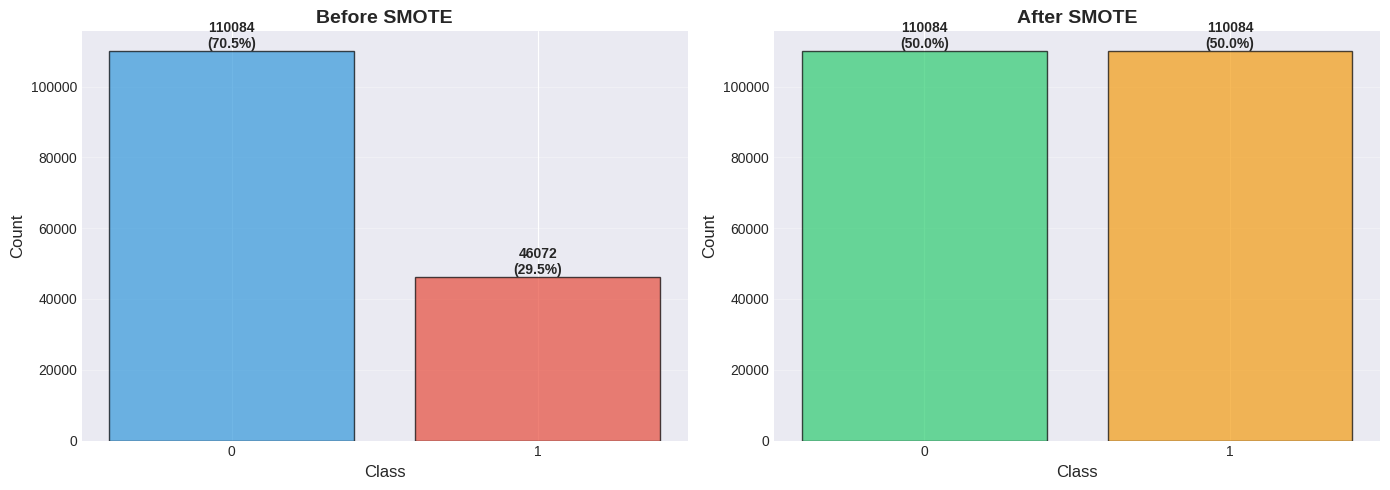


✅ SMOTE applied successfully
   Original samples: 156,156
   Balanced samples: 220,168
   Synthetic samples created: 64,012

📊 Final training set: (220168, 100)
📊 Final test set: (39040, 100)


In [17]:
print("🔄 HANDLING CLASS IMBALANCE WITH SMOTE")
print("=" * 80)

if X_train_scaled is not None and y_train is not None and imbalance_info is not None:

    if imbalance_info['needs_handling']:
        print(f"\n⚖️ Class imbalance detected (ratio: {imbalance_info['ratio']:.2f}:1)")
        print("   Applying SMOTE to training data...")

        # Original distribution
        print(f"\n📊 Before SMOTE:")
        print(f"   Training samples: {len(y_train)}")
        print(y_train.value_counts())

        # Apply SMOTE
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

        # Convert back to DataFrame
        X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_scaled.columns)

        print(f"\n📊 After SMOTE:")
        print(f"   Training samples: {len(y_train_balanced)}")
        print(y_train_balanced.value_counts())

        # Visualize the effect
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Before SMOTE
        before_counts = y_train.value_counts()
        axes[0].bar(before_counts.index.astype(str), before_counts.values,
                   color=['#3498db', '#e74c3c'], edgecolor='black', alpha=0.7)
        axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Class', fontsize=12)
        axes[0].set_ylabel('Count', fontsize=12)
        axes[0].grid(axis='y', alpha=0.3)

        for i, (idx, val) in enumerate(before_counts.items()):
            axes[0].text(i, val, f'{val}\n({val/len(y_train)*100:.1f}%)',
                        ha='center', va='bottom', fontweight='bold')

        # After SMOTE
        after_counts = y_train_balanced.value_counts()
        axes[1].bar(after_counts.index.astype(str), after_counts.values,
                   color=['#2ecc71', '#f39c12'], edgecolor='black', alpha=0.7)
        axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Class', fontsize=12)
        axes[1].set_ylabel('Count', fontsize=12)
        axes[1].grid(axis='y', alpha=0.3)

        for i, (idx, val) in enumerate(after_counts.items()):
            axes[1].text(i, val, f'{val}\n({val/len(y_train_balanced)*100:.1f}%)',
                        ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        print(f"\n✅ SMOTE applied successfully")
        print(f"   Original samples: {len(y_train):,}")
        print(f"   Balanced samples: {len(y_train_balanced):,}")
        print(f"   Synthetic samples created: {len(y_train_balanced) - len(y_train):,}")

    else:
        print(f"\n✅ Classes are relatively balanced (ratio: {imbalance_info['ratio']:.2f}:1)")
        print("   SMOTE not needed - using original training data")
        X_train_balanced = X_train_scaled
        y_train_balanced = y_train

    # Keep test set unchanged
    X_test_final = X_test_scaled
    y_test_final = y_test

    print(f"\n📊 Final training set: {X_train_balanced.shape}")
    print(f"📊 Final test set: {X_test_final.shape}")

else:
    print("❌ Cannot apply SMOTE - required data not available")
    X_train_balanced = y_train_balanced = X_test_final = y_test_final = None

print("=" * 80)

In [19]:
print("🤖 BASELINE MODELS - INITIAL TRAINING")
print("=" * 80)

if X_train_balanced is not None and y_train_balanced is not None:

    # Dictionary to store models and results
    baseline_models = {}
    baseline_results = {}

    print("\n🎯 Training multiple baseline models...\n")

    # 1. Logistic Regression
    print("1️⃣ Logistic Regression")
    print("-" * 40)
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_balanced, y_train_balanced)
    lr_pred = lr_model.predict(X_test_final)
    lr_pred_proba = lr_model.predict_proba(X_test_final)[:, 1]

    baseline_models['Logistic Regression'] = lr_model
    baseline_results['Logistic Regression'] = {
        'predictions': lr_pred,
        'probabilities': lr_pred_proba,
        'accuracy': accuracy_score(y_test_final, lr_pred),
        'precision': precision_score(y_test_final, lr_pred, average='binary'),
        'recall': recall_score(y_test_final, lr_pred, average='binary'),
        'f1': f1_score(y_test_final, lr_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, lr_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['Logistic Regression']['accuracy']:.4f}")

    # 2. Decision Tree
    print("\n2️⃣ Decision Tree")
    print("-" * 40)
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')
    dt_model.fit(X_train_balanced, y_train_balanced)
    dt_pred = dt_model.predict(X_test_final)
    dt_pred_proba = dt_model.predict_proba(X_test_final)[:, 1]

    baseline_models['Decision Tree'] = dt_model
    baseline_results['Decision Tree'] = {
        'predictions': dt_pred,
        'probabilities': dt_pred_proba,
        'accuracy': accuracy_score(y_test_final, dt_pred),
        'precision': precision_score(y_test_final, dt_pred, average='binary'),
        'recall': recall_score(y_test_final, dt_pred, average='binary'),
        'f1': f1_score(y_test_final, dt_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, dt_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['Decision Tree']['accuracy']:.4f}")

    # 3. Random Forest
    print("\n3️⃣ Random Forest")
    print("-" * 40)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                     max_depth=15, class_weight='balanced')
    rf_model.fit(X_train_balanced, y_train_balanced)
    rf_pred = rf_model.predict(X_test_final)
    rf_pred_proba = rf_model.predict_proba(X_test_final)[:, 1]

    baseline_models['Random Forest'] = rf_model
    baseline_results['Random Forest'] = {
        'predictions': rf_pred,
        'probabilities': rf_pred_proba,
        'accuracy': accuracy_score(y_test_final, rf_pred),
        'precision': precision_score(y_test_final, rf_pred, average='binary'),
        'recall': recall_score(y_test_final, rf_pred, average='binary'),
        'f1': f1_score(y_test_final, rf_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, rf_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['Random Forest']['accuracy']:.4f}")

    # 4. Gradient Boosting
    print("\n4️⃣ Gradient Boosting")
    print("-" * 40)
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42,
                                         max_depth=5, learning_rate=0.1)
    gb_model.fit(X_train_balanced, y_train_balanced)
    gb_pred = gb_model.predict(X_test_final)
    gb_pred_proba = gb_model.predict_proba(X_test_final)[:, 1]

    baseline_models['Gradient Boosting'] = gb_model
    baseline_results['Gradient Boosting'] = {
        'predictions': gb_pred,
        'probabilities': gb_pred_proba,
        'accuracy': accuracy_score(y_test_final, gb_pred),
        'precision': precision_score(y_test_final, gb_pred, average='binary'),
        'recall': recall_score(y_test_final, gb_pred, average='binary'),
        'f1': f1_score(y_test_final, gb_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, gb_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['Gradient Boosting']['accuracy']:.4f}")

    # 5. XGBoost
    print("\n5️⃣ XGBoost")
    print("-" * 40)
    xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=6,
                             learning_rate=0.1, eval_metric='logloss')
    xgb_model.fit(X_train_balanced, y_train_balanced)
    xgb_pred = xgb_model.predict(X_test_final)
    xgb_pred_proba = xgb_model.predict_proba(X_test_final)[:, 1]

    baseline_models['XGBoost'] = xgb_model
    baseline_results['XGBoost'] = {
        'predictions': xgb_pred,
        'probabilities': xgb_pred_proba,
        'accuracy': accuracy_score(y_test_final, xgb_pred),
        'precision': precision_score(y_test_final, xgb_pred, average='binary'),
        'recall': recall_score(y_test_final, xgb_pred, average='binary'),
        'f1': f1_score(y_test_final, xgb_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, xgb_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['XGBoost']['accuracy']:.4f}")

    # 6. LightGBM
    print("\n6️⃣ LightGBM")
    print("-" * 40)
    lgbm_model = LGBMClassifier(n_estimators=100, random_state=42, max_depth=6,
                               learning_rate=0.1, verbose=-1)
    lgbm_model.fit(X_train_balanced, y_train_balanced)
    lgbm_pred = lgbm_model.predict(X_test_final)
    lgbm_pred_proba = lgbm_model.predict_proba(X_test_final)[:, 1]

    baseline_models['LightGBM'] = lgbm_model
    baseline_results['LightGBM'] = {
      'predictions': lgbm_pred,
      'probabilities': lgbm_pred_proba,
      'accuracy': accuracy_score(y_test_final, lgbm_pred),
      'precision': precision_score(y_test_final, lgbm_pred, average='binary'),
      'recall': recall_score(y_test_final, lgbm_pred, average='binary'),
      'f1': f1_score(y_test_final, lgbm_pred, average='binary'),
      'roc_auc': roc_auc_score(y_test_final, lgbm_pred_proba)
    }
    print(f"   ✅ Trained - Accuracy: {baseline_results['LightGBM']['accuracy']:.4f}")

    print("\n" + "=" * 80)
    print("✅ ALL BASELINE MODELS TRAINED SUCCESSFULLY")
    print("=" * 80)

else:
    print("❌ Cannot train models - training data not available")
    baseline_models = {}
    baseline_results = {}

🤖 BASELINE MODELS - INITIAL TRAINING

🎯 Training multiple baseline models...

1️⃣ Logistic Regression
----------------------------------------
   ✅ Trained - Accuracy: 0.8974

2️⃣ Decision Tree
----------------------------------------
   ✅ Trained - Accuracy: 0.8984

3️⃣ Random Forest
----------------------------------------
   ✅ Trained - Accuracy: 0.9005

4️⃣ Gradient Boosting
----------------------------------------
   ✅ Trained - Accuracy: 0.9009

5️⃣ XGBoost
----------------------------------------
   ✅ Trained - Accuracy: 0.9023

6️⃣ LightGBM
----------------------------------------
   ✅ Trained - Accuracy: 0.9015

✅ ALL BASELINE MODELS TRAINED SUCCESSFULLY


📊 BASELINE MODELS - PERFORMANCE COMPARISON

📋 Performance Metrics Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.900512   0.820487 0.848411  0.834215 0.941878
            XGBoost  0.902280   0.831312 0.839035  0.835155 0.938923
           LightGBM  0.901511   0.829116 0.839121  0.834088 0.938665
  Gradient Boosting  0.900871   0.828128 0.837906  0.832988 0.937759
Logistic Regression  0.897413   0.811200 0.850148  0.830217 0.926486
      Decision Tree  0.898412   0.820109 0.839903  0.829888 0.924571


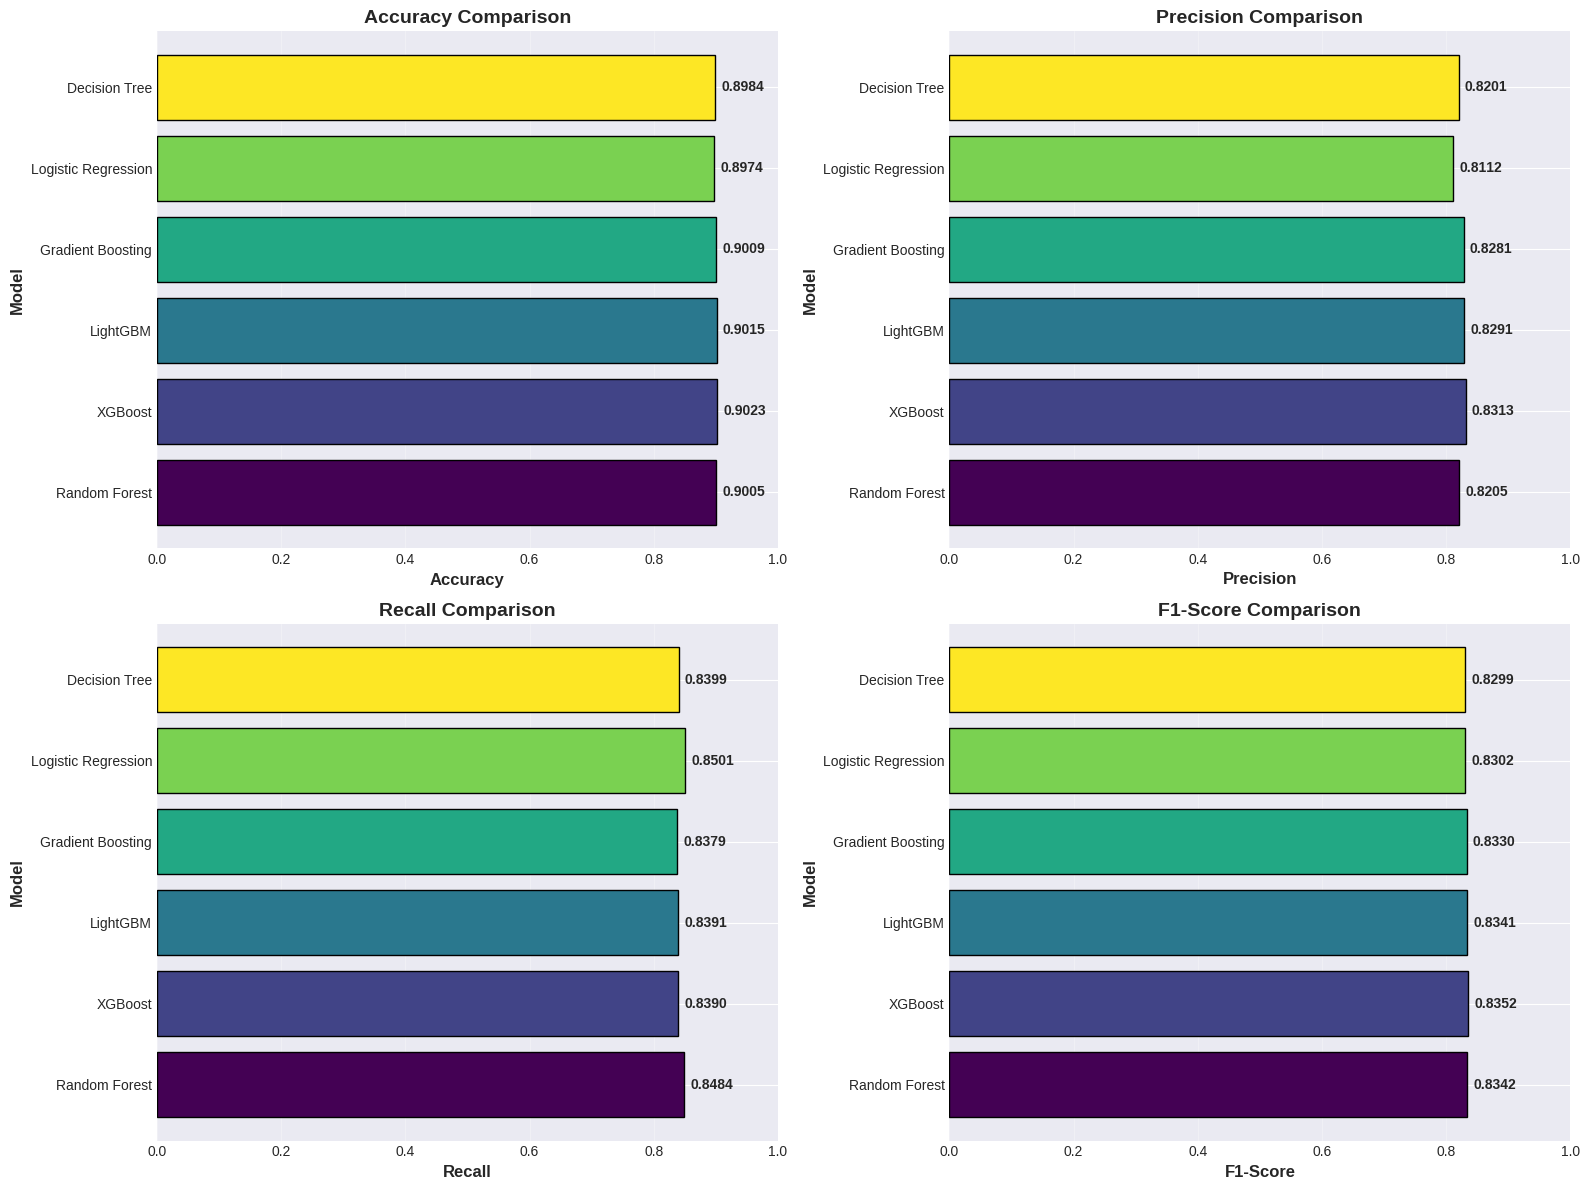


📈 ROC Curves:


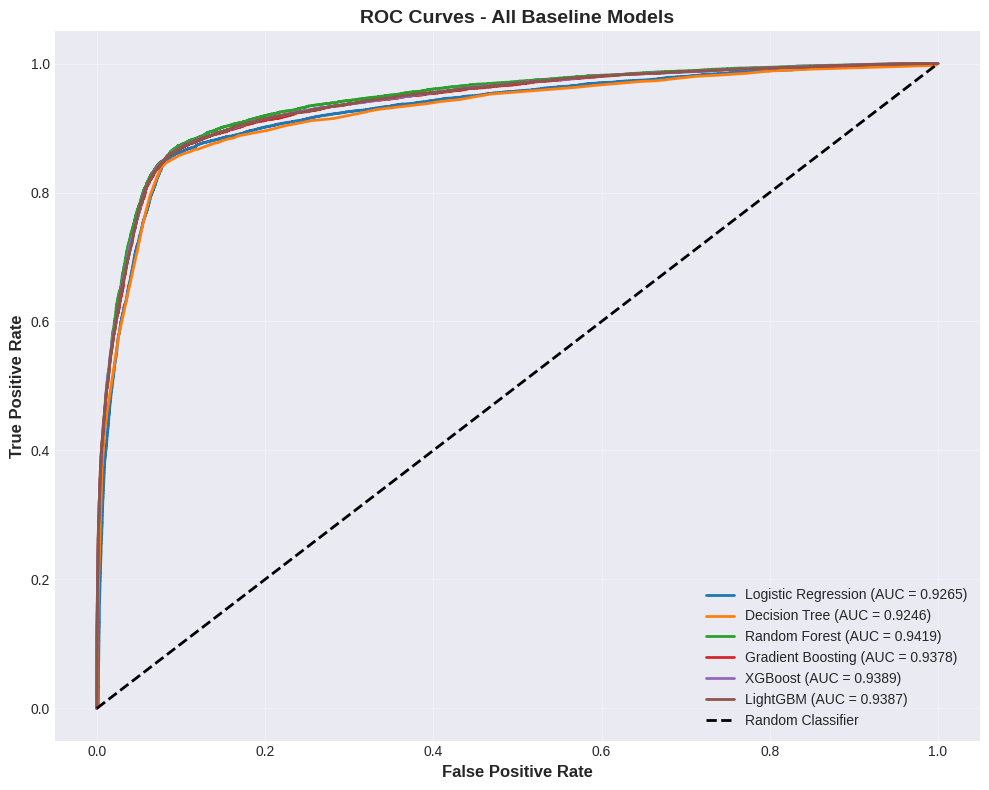


🏆 BEST BASELINE MODEL: Random Forest
   ROC-AUC Score: 0.9419

📊 Confusion Matrices - Top 3 Models:


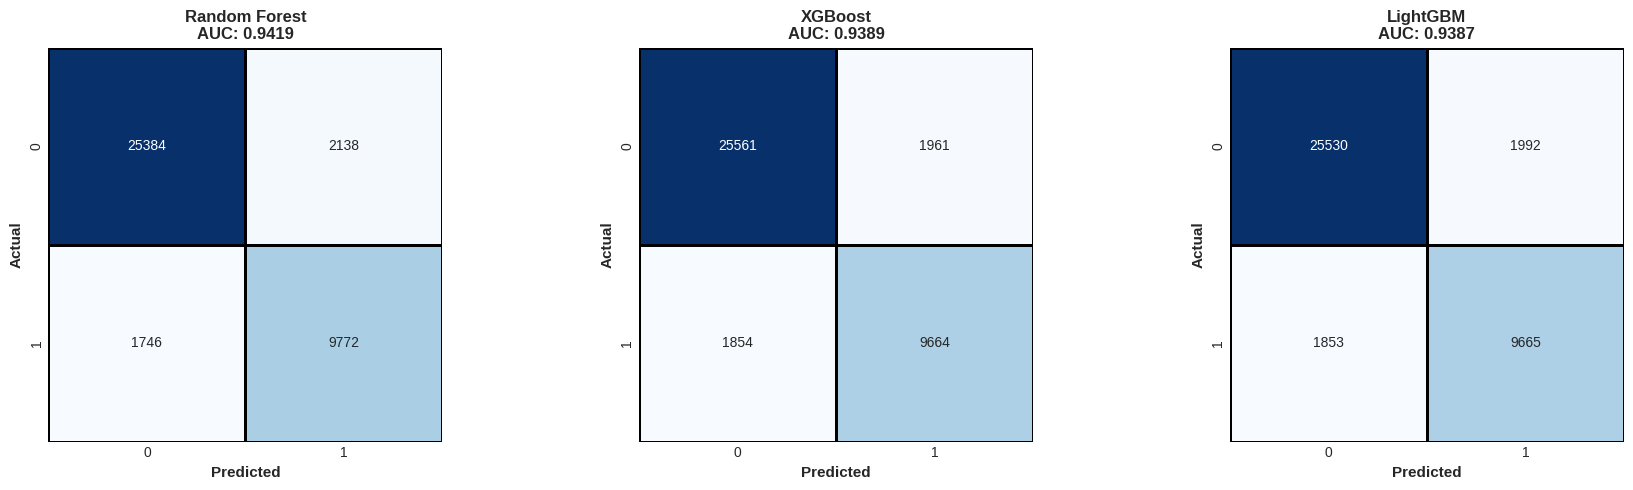


📋 Detailed Classification Report - Random Forest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     27522
           1       0.82      0.85      0.83     11518

    accuracy                           0.90     39040
   macro avg       0.88      0.89      0.88     39040
weighted avg       0.90      0.90      0.90     39040



In [20]:
print("📊 BASELINE MODELS - PERFORMANCE COMPARISON")
print("=" * 80)

if baseline_results:
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': list(baseline_results.keys()),
        'Accuracy': [results['accuracy'] for results in baseline_results.values()],
        'Precision': [results['precision'] for results in baseline_results.values()],
        'Recall': [results['recall'] for results in baseline_results.values()],
        'F1-Score': [results['f1'] for results in baseline_results.values()],
        'ROC-AUC': [results['roc_auc'] for results in baseline_results.values()]
    }).sort_values('ROC-AUC', ascending=False)

    print("\n📋 Performance Metrics Comparison:")
    print(comparison_df.to_string(index=False))

    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        bars = ax.barh(comparison_df['Model'], comparison_df[metric], color=colors, edgecolor='black')
        ax.set_xlabel(metric, fontsize=12, fontweight='bold')
        ax.set_ylabel('Model', fontsize=12, fontweight='bold')
        ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
        ax.set_xlim([0, 1])
        ax.grid(axis='x', alpha=0.3)

        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, comparison_df[metric])):
            ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    print("\n📈 ROC Curves:")
    plt.figure(figsize=(10, 8))

    for model_name, results in baseline_results.items():
        fpr, tpr, _ = roc_curve(y_test_final, results['probabilities'])
        auc_score = results['roc_auc']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - All Baseline Models', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Identify best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_auc = comparison_df.iloc[0]['ROC-AUC']

    print(f"\n🏆 BEST BASELINE MODEL: {best_model_name}")
    print(f"   ROC-AUC Score: {best_auc:.4f}")

    # Confusion matrices for top 3 models
    print("\n📊 Confusion Matrices - Top 3 Models:")

    top_3_models = comparison_df.head(3)['Model'].tolist()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, model_name in enumerate(top_3_models):
        cm = confusion_matrix(y_test_final, baseline_results[model_name]['predictions'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   cbar=False, square=True, linewidths=2, linecolor='black')
        axes[idx].set_title(f'{model_name}\nAUC: {baseline_results[model_name]["roc_auc"]:.4f}',
                          fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Actual', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Detailed classification report for best model
    print(f"\n📋 Detailed Classification Report - {best_model_name}:")
    print("-" * 80)
    print(classification_report(y_test_final, baseline_results[best_model_name]['predictions']))

else:
    print("❌ No baseline results available")

print("=" * 80)

In [ ]:
print("⚙️ HYPERPARAMETER TUNING - XGBOOST")
print("=" * 80)

if X_train_balanced is not None and y_train_balanced is not None:

    print("\n🔧 Setting up GridSearchCV for XGBoost...")

    # Define parameter grid
    param_grid_xgb = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2]
    }

    print(f"\n📊 Parameter grid:")
    print(f"   n_estimators: {param_grid_xgb['n_estimators']}")
    print(f"   max_depth: {param_grid_xgb['max_depth']}")
    print(f"   learning_rate: {param_grid_xgb['learning_rate']}")
    print(f"   subsample: {param_grid_xgb['subsample']}")
    print(f"   colsample_bytree: {param_grid_xgb['colsample_bytree']}")
    print(f"   min_child_weight: {param_grid_xgb['min_child_weight']}")
    print(f"   gamma: {param_grid_xgb['gamma']}")

    total_combinations = np.prod([len(v) for v in param_grid_xgb.values()])
    print(f"\n⚠️ Total combinations: {total_combinations}")
    print(f"   This might take a while... Using RandomizedSearchCV instead for efficiency")

    # Use RandomizedSearchCV for faster tuning
    print("\n🚀 Running RandomizedSearchCV (50 iterations)...")

    xgb_random = RandomizedSearchCV(
        XGBClassifier(random_state=42, eval_metric='logloss'),
        param_distributions=param_grid_xgb,
        n_iter=50,  # Number of parameter combinations to try
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    xgb_random.fit(X_train_balanced, y_train_balanced)

    print("\n✅ Hyperparameter tuning completed!")

    # Best parameters
    print("\n🏆 BEST PARAMETERS:")
    print("-" * 80)
    for param, value in xgb_random.best_params_.items():
        print(f"   {param}: {value}")

    print(f"\n📊 Best Cross-Validation ROC-AUC Score: {xgb_random.best_score_:.4f}")

    # Train final model with best parameters
    print("\n🔧 Training final XGBoost model with best parameters...")
    xgb_tuned = xgb_random.best_estimator_

    # Evaluate on test set
    xgb_tuned_pred = xgb_tuned.predict(X_test_final)
    xgb_tuned_proba = xgb_tuned.predict_proba(X_test_final)[:, 1]

    xgb_tuned_results = {
        'accuracy': accuracy_score(y_test_final, xgb_tuned_pred),
        'precision': precision_score(y_test_final, xgb_tuned_pred, average='binary'),
        'recall': recall_score(y_test_final, xgb_tuned_pred, average='binary'),
        'f1': f1_score(y_test_final, xgb_tuned_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, xgb_tuned_proba)
    }

    print("\n📊 TUNED MODEL PERFORMANCE:")
    print("-" * 80)
    for metric, value in xgb_tuned_results.items():
        print(f"   {metric.upper()}: {value:.4f}")

    # Compare with baseline XGBoost
    if 'XGBoost' in baseline_results:
        print("\n📈 IMPROVEMENT OVER BASELINE:")
        print("-" * 80)
        for metric in xgb_tuned_results.keys():
            baseline_val = baseline_results['XGBoost'][metric]
            tuned_val = xgb_tuned_results[metric]
            improvement = ((tuned_val - baseline_val) / baseline_val) * 100
            print(f"   {metric.upper()}: {baseline_val:.4f} → {tuned_val:.4f} ({improvement:+.2f}%)")

else:
    print("❌ Cannot perform hyperparameter tuning - training data not available")
    xgb_tuned = None
    xgb_tuned_results = None

print("=" * 80)

⚙️ HYPERPARAMETER TUNING - XGBOOST

🔧 Setting up GridSearchCV for XGBoost...

📊 Parameter grid:
   n_estimators: [100, 200, 300]
   max_depth: [4, 6, 8, 10]
   learning_rate: [0.01, 0.05, 0.1]
   subsample: [0.8, 0.9, 1.0]
   colsample_bytree: [0.8, 0.9, 1.0]
   min_child_weight: [1, 3, 5]
   gamma: [0, 0.1, 0.2]

⚠️ Total combinations: 2916
   This might take a while... Using RandomizedSearchCV instead for efficiency

🚀 Running RandomizedSearchCV (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
print("⚙️ HYPERPARAMETER TUNING - RANDOM FOREST")
print("=" * 80)

if X_train_balanced is not None and y_train_balanced is not None:

    print("\n🔧 Setting up RandomizedSearchCV for Random Forest...")

    # Define parameter grid
    param_grid_rf = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': ['balanced', 'balanced_subsample']
    }

    print(f"\n📊 Parameter grid:")
    for param, values in param_grid_rf.items():
        print(f"   {param}: {values}")

    print("\n🚀 Running RandomizedSearchCV (50 iterations)...")

    rf_random = RandomizedSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=param_grid_rf,
        n_iter=50,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    rf_random.fit(X_train_balanced, y_train_balanced)

    print("\n✅ Hyperparameter tuning completed!")

    # Best parameters
    print("\n🏆 BEST PARAMETERS:")
    print("-" * 80)
    for param, value in rf_random.best_params_.items():
        print(f"   {param}: {value}")

    print(f"\n📊 Best Cross-Validation ROC-AUC Score: {rf_random.best_score_:.4f}")

    # Train final model
    print("\n🔧 Training final Random Forest model with best parameters...")
    rf_tuned = rf_random.best_estimator_

    # Evaluate on test set
    rf_tuned_pred = rf_tuned.predict(X_test_final)
    rf_tuned_proba = rf_tuned.predict_proba(X_test_final)[:, 1]

    rf_tuned_results = {
        'accuracy': accuracy_score(y_test_final, rf_tuned_pred),
        'precision': precision_score(y_test_final, rf_tuned_pred, average='binary'),
        'recall': recall_score(y_test_final, rf_tuned_pred, average='binary'),
        'f1': f1_score(y_test_final, rf_tuned_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, rf_tuned_proba)
    }

    print("\n📊 TUNED MODEL PERFORMANCE:")
    print("-" * 80)
    for metric, value in rf_tuned_results.items():
        print(f"   {metric.upper()}: {value:.4f}")

    # Compare with baseline
    if 'Random Forest' in baseline_results:
        print("\n📈 IMPROVEMENT OVER BASELINE:")
        print("-" * 80)
        for metric in rf_tuned_results.keys():
            baseline_val = baseline_results['Random Forest'][metric]
            tuned_val = rf_tuned_results[metric]
            improvement = ((tuned_val - baseline_val) / baseline_val) * 100
            print(f"   {metric.upper()}: {baseline_val:.4f} → {tuned_val:.4f} ({improvement:+.2f}%)")

else:
    print("❌ Cannot perform hyperparameter tuning - training data not available")
    rf_tuned = None
    rf_tuned_results = None

print("=" * 80)

In [ ]:
print("⚙️ HYPERPARAMETER TUNING - LIGHTGBM")
print("=" * 80)

if X_train_balanced is not None and y_train_balanced is not None:

    print("\n🔧 Setting up RandomizedSearchCV for LightGBM...")

    # Define parameter grid
    param_grid_lgbm = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [4, 6, 8, 10, -1],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'num_leaves': [20, 31, 40, 50],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    print(f"\n📊 Parameter grid:")
    for param, values in param_grid_lgbm.items():
        print(f"   {param}: {values}")

    print("\n🚀 Running RandomizedSearchCV (50 iterations)...")

    lgbm_random = RandomizedSearchCV(
        LGBMClassifier(random_state=42, verbose=-1),
        param_distributions=param_grid_lgbm,
        n_iter=50,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    lgbm_random.fit(X_train_balanced, y_train_balanced)

    print("\n✅ Hyperparameter tuning completed!")

    # Best parameters
    print("\n🏆 BEST PARAMETERS:")
    print("-" * 80)
    for param, value in lgbm_random.best_params_.items():
        print(f"   {param}: {value}")

    print(f"\n📊 Best Cross-Validation ROC-AUC Score: {lgbm_random.best_score_:.4f}")

    # Train final model
    print("\n🔧 Training final LightGBM model with best parameters...")
    lgbm_tuned = lgbm_random.best_estimator_

    # Evaluate on test set
    lgbm_tuned_pred = lgbm_tuned.predict(X_test_final)
    lgbm_tuned_proba = lgbm_tuned.predict_proba(X_test_final)[:, 1]

    lgbm_tuned_results = {
        'accuracy': accuracy_score(y_test_final, lgbm_tuned_pred),
        'precision': precision_score(y_test_final, lgbm_tuned_pred, average='binary'),
        'recall': recall_score(y_test_final, lgbm_tuned_pred, average='binary'),
        'f1': f1_score(y_test_final, lgbm_tuned_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, lgbm_tuned_proba)
    }

    print("\n📊 TUNED MODEL PERFORMANCE:")
    print("-" * 80)
    for metric, value in lgbm_tuned_results.items():
        print(f"   {metric.upper()}: {value:.4f}")

    # Compare with baseline
    if 'LightGBM' in baseline_results:
        print("\n📈 IMPROVEMENT OVER BASELINE:")
        print("-" * 80)
        for metric in lgbm_tuned_results.keys():
            baseline_val = baseline_results['LightGBM'][metric]
            tuned_val = lgbm_tuned_results[metric]
            improvement = ((tuned_val - baseline_val) / baseline_val) * 100
            print(f"   {metric.upper()}: {baseline_val:.4f} → {tuned_val:.4f} ({improvement:+.2f}%)")

else:
    print("❌ Cannot perform hyperparameter tuning - training data not available")
    lgbm_tuned = None
    lgbm_tuned_results = None

print("=" * 80)

In [ ]:
print("🎭 ENSEMBLE MODEL - VOTING CLASSIFIER")
print("=" * 80)

if xgb_tuned is not None and rf_tuned is not None and lgbm_tuned is not None:

    print("\n🔧 Creating Voting Classifier ensemble...")
    print("   Combining: XGBoost + Random Forest + LightGBM")

    # Create voting classifier (soft voting for probability-based voting)
    voting_clf = VotingClassifier(
        estimators=[
            ('xgb', xgb_tuned),
            ('rf', rf_tuned),
            ('lgbm', lgbm_tuned)
        ],
        voting='soft',  # Use predicted probabilities
        n_jobs=-1
    )

    print("\n🚀 Training Voting Classifier...")
    voting_clf.fit(X_train_balanced, y_train_balanced)

    # Make predictions
    voting_pred = voting_clf.predict(X_test_final)
    voting_proba = voting_clf.predict_proba(X_test_final)[:, 1]

    # Calculate metrics
    voting_results = {
        'accuracy': accuracy_score(y_test_final, voting_pred),
        'precision': precision_score(y_test_final, voting_pred, average='binary'),
        'recall': recall_score(y_test_final, voting_pred, average='binary'),
        'f1': f1_score(y_test_final, voting_pred, average='binary'),
        'roc_auc': roc_auc_score(y_test_final, voting_proba)
    }

    print("\n✅ Voting Classifier trained successfully!")

    print("\n📊 ENSEMBLE MODEL PERFORMANCE:")
    print("-" * 80)
    for metric, value in voting_results.items():
        print(f"   {metric.upper()}: {value:.4f}")

    # Compare with individual tuned models
    print("\n📈 COMPARISON WITH INDIVIDUAL MODELS:")
    print("-" * 80)

    comparison_data = {
        'XGBoost (Tuned)': xgb_tuned_results,
        'Random Forest (Tuned)': rf_tuned_results,
        'LightGBM (Tuned)': lgbm_tuned_results,
        'Voting Ensemble': voting_results
    }

    comparison_ensemble = pd.DataFrame(comparison_data).T
    print(comparison_ensemble)

    # Visualize comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    metrics_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    for idx, metric in enumerate(metrics_list):
        ax = axes[idx]
        values = [results[metric] for results in comparison_data.values()]
        models = list(comparison_data.keys())

        colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
        bars = ax.bar(range(len(models)), values, color=colors, edgecolor='black', alpha=0.8)

        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=15, ha='right')
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        ax.set_title(f'{metric.replace("_", " ").title()} Comparison',
                    fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, values)):
            ax.text(i, val + 0.01, f'{val:.4f}', ha='center', va='bottom',
                   fontweight='bold', fontsize=9)

    # Hide the last subplot
    axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

    # Determine if ensemble is better
    best_individual = max([xgb_tuned_results['roc_auc'],
                          rf_tuned_results['roc_auc'],
                          lgbm_tuned_results['roc_auc']])

    if voting_results['roc_auc'] > best_individual:
        improvement = ((voting_results['roc_auc'] - best_individual) / best_individual) * 100
        print(f"\n🎉 ENSEMBLE OUTPERFORMS INDIVIDUAL MODELS!")
        print(f"   Best Individual AUC: {best_individual:.4f}")
        print(f"   Ensemble AUC: {voting_results['roc_auc']:.4f}")
        print(f"   Improvement: +{improvement:.2f}%")
    else:
        print(f"\n📊 Best individual model still performs better")
        print(f"   Best Individual AUC: {best_individual:.4f}")
        print(f"   Ensemble AUC: {voting_results['roc_auc']:.4f}")

else:
    print("❌ Cannot create ensemble - tuned models not available")
    voting_clf = None
    voting_results = None

print("=" * 80)

In [ ]:
print("🏆 FINAL MODEL SELECTION AND COMPREHENSIVE EVALUATION")
print("=" * 80)

# Collect all model results
all_models_results = {}

# Add baseline models
if baseline_results:
    for name, results in baseline_results.items():
        all_models_results[name] = results

# Add tuned models
if xgb_tuned_results:
    all_models_results['XGBoost (Tuned)'] = xgb_tuned_results
if rf_tuned_results:
    all_models_results['Random Forest (Tuned)'] = rf_tuned_results
if lgbm_tuned_results:
    all_models_results['LightGBM (Tuned)'] = lgbm_tuned_results
if voting_results:
    all_models_results['Voting Ensemble'] = voting_results

# Create comprehensive comparison
if all_models_results:
    print("\n📊 ALL MODELS PERFORMANCE SUMMARY:")
    print("=" * 80)

    final_comparison = pd.DataFrame({
        'Model': list(all_models_results.keys()),
        'Accuracy': [r['accuracy'] for r in all_models_results.values()],
        'Precision': [r['precision'] for r in all_models_results.values()],
        'Recall': [r['recall'] for r in all_models_results.values()],
        'F1-Score': [r['f1'] for r in all_models_results.values()],
        'ROC-AUC': [r['roc_auc'] for r in all_models_results.values()]
    }).sort_values('ROC-AUC', ascending=False)

    print(final_comparison.to_string(index=False))

    # Select best model
    best_model_name = final_comparison.iloc[0]['Model']
    best_model_metrics = all_models_results[best_model_name]

    print(f"\n🥇 BEST MODEL: {best_model_name}")
    print("=" * 80)
    print(f"   Accuracy:  {best_model_metrics['accuracy']:.4f}")
    print(f"   Precision: {best_model_metrics['precision']:.4f}")
    print(f"   Recall:    {best_model_metrics['recall']:.4f}")
    print(f"   F1-Score:  {best_model_metrics['f1']:.4f}")
    print(f"   ROC-AUC:   {best_model_metrics['roc_auc']:.4f}")

    # Get the actual best model object
    if best_model_name == 'XGBoost (Tuned)':
        final_model = xgb_tuned
        final_predictions = xgb_tuned_pred
        final_probabilities = xgb_tuned_proba
    elif best_model_name == 'Random Forest (Tuned)':
        final_model = rf_tuned
        final_predictions = rf_tuned_pred
        final_probabilities = rf_tuned_proba
    elif best_model_name == 'LightGBM (Tuned)':
        final_model = lgbm_tuned
        final_predictions = lgbm_tuned_pred
        final_probabilities = lgbm_tuned_proba
    elif best_model_name == 'Voting Ensemble':
        final_model = voting_clf
        final_predictions = voting_pred
        final_probabilities = voting_proba
    else:
        # Use from baseline
        final_model = baseline_models[best_model_name]
        final_predictions = baseline_results[best_model_name]['predictions']
        final_probabilities = baseline_results[best_model_name]['probabilities']

    # Detailed evaluation of best model
    print("\n" + "=" * 80)
    print(f"DETAILED EVALUATION - {best_model_name}")
    print("=" * 80)

    # 1. Confusion Matrix
    print("\n1️⃣ CONFUSION MATRIX:")
    print("-" * 80)
    cm = confusion_matrix(y_test_final, final_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                square=True, linewidths=2, linecolor='black',
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {best_model_name}',
             fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')

    # Add percentages
    cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.7, f'({cm_percentages[i, j]*100:.1f}%)',
                    ha='center', va='center', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

    # Calculate confusion matrix metrics
    tn, fp, fn, tp = cm.ravel()

    print(f"\n   True Negatives:  {tn:,}")
    print(f"   False Positives: {fp:,}")
    print(f"   False Negatives: {fn:,}")
    print(f"   True Positives:  {tp:,}")
    print(f"\n   Sensitivity (TPR): {tp/(tp+fn):.4f}")
    print(f"   Specificity (TNR): {tn/(tn+fp):.4f}")
    print(f"   False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"   False Negative Rate: {fn/(fn+tp):.4f}")

    # 2. ROC Curve
    print("\n2️⃣ ROC CURVE:")
    print("-" * 80)

    fpr, tpr, thresholds = roc_curve(y_test_final, final_probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3,
            label=f'{best_model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
            label='Random Classifier (AUC = 0.5000)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Precision-Recall Curve
    print("\n3️⃣ PRECISION-RECALL CURVE:")
    print("-" * 80)

    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(
        y_test_final, final_probabilities
    )
    avg_precision = average_precision_score(y_test_final, final_probabilities)

    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, color='blue', lw=3,
            label=f'{best_model_name} (AP = {avg_precision:.4f})')
    plt.xlabel('Recall', fontsize=13, fontweight='bold')
    plt.ylabel('Precision', fontsize=13, fontweight='bold')
    plt.title(f'Precision-Recall Curve - {best_model_name}',
             fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=11)
    plt.grid(alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.tight_layout()
    plt.show()

    print(f"   Average Precision Score: {avg_precision:.4f}")

    # 4. Classification Report
    print("\n4️⃣ CLASSIFICATION REPORT:")
    print("-" * 80)
    print(classification_report(y_test_final, final_predictions,
                               target_names=['No Dementia', 'Dementia']))

    # 5. Prediction distribution
    print("\n5️⃣ PREDICTION PROBABILITY DISTRIBUTION:")
    print("-" * 80)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Histogram
    axes[0].hist(final_probabilities[y_test_final == 0], bins=50, alpha=0.6,
                label='No Dementia (Actual)', color='green', edgecolor='black')
    axes[0].hist(final_probabilities[y_test_final == 1], bins=50, alpha=0.6,
                label='Dementia (Actual)', color='red', edgecolor='black')
    axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold = 0.5')
    axes[0].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution of Predicted Probabilities',
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)

    # Box plot
    prob_df = pd.DataFrame({
        'Probability': final_probabilities,
        'Actual': ['No Dementia' if y == 0 else 'Dementia' for y in y_test_final]
    })

    prob_df.boxplot(column='Probability', by='Actual', ax=axes[1])
    axes[1].set_xlabel('Actual Class', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Predicted Probability', fontsize=12, fontweight='bold')
    axes[1].set_title('Probability Distribution by Actual Class',
                     fontsize=14, fontweight='bold')
    axes[1].get_figure().suptitle('')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("\n   Probability Statistics by Actual Class:")
    print(prob_df.groupby('Actual')['Probability'].describe())

else:
    print("❌ No model results available")
    final_model = None

print("\n" + "=" * 80)
print("✅ FINAL MODEL EVALUATION COMPLETED")
print("=" * 80)

In [ ]:
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

if final_model is not None and hasattr(final_model, 'feature_importances_'):

    print(f"\n📊 Analyzing feature importance for: {best_model_name}")

    # Get feature importances
    if best_model_name == 'Voting Ensemble':
        # Average importance across ensemble members
        print("\n   Calculating average importance across ensemble members...")

        importances_list = []
        for name, estimator in voting_clf.named_estimators_.items():
            if hasattr(estimator, 'feature_importances_'):
                importances_list.append(estimator.feature_importances_)

        feature_importance = np.mean(importances_list, axis=0)
    else:
        feature_importance = final_model.feature_importances_

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'Feature': X_train_balanced.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print("\n🔝 TOP 30 MOST IMPORTANT FEATURES:")
    print("-" * 80)
    print(importance_df.head(30).to_string(index=False))

    # Visualize top 30 features
    plt.figure(figsize=(12, 10))
    top_30 = importance_df.head(30)
    colors = plt.cm.viridis(top_30['Importance'] / top_30['Importance'].max())

    plt.barh(range(len(top_30)), top_30['Importance'], color=colors, edgecolor='black')
    plt.yticks(range(len(top_30)), top_30['Feature'], fontsize=10)
    plt.xlabel('Feature Importance', fontsize=13, fontweight='bold')
    plt.ylabel('Features', fontsize=13, fontweight='bold')
    plt.title(f'Top 30 Most Important Features - {best_model_name}',
             fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Categorize features by type
    print("\n📋 FEATURE IMPORTANCE BY CATEGORY:")
    print("-" * 80)

    # Define feature categories (based on our engineered features)
    feature_categories = {
        'Age-Related': ['NACCAGE', 'age_group', 'age_squared', 'is_senior', 'age_risk_category'],
        'Education': ['EDUC', 'education_level', 'low_education', 'cognitive_reserve'],
        'Cardiovascular': ['cardio_risk_score', 'cardio_condition_count', 'CVHATT',
                          'CBSTROKE', 'HYPERTEN', 'BPSYS', 'BPDIAS'],
        'Metabolic': ['DIABETES', 'NACCBMI', 'metabolic_condition_count', 'HYPERCHO'],
        'Lifestyle': ['TOBAC30', 'TOBAC100', 'ALCOCCAS', 'pack_years', 'ever_smoked'],
        'Social/Living': ['MARISTAT', 'NACCLIVS', 'lives_alone', 'social_support_score'],
        'Family History': ['NACCFAM', 'NACCMOM', 'NACCDAD', 'family_history_cognitive'],
        'Mental Health': ['DEP2YRS', 'ANXIETY', 'mental_health_count', 'has_depression'],
        'Physical Health': ['HEIGHT', 'WEIGHT', 'VISION', 'HEARING'],
        'Medications': ['NACCAMD', 'polypharmacy', 'NACCAHTN'],
        'Composite Scores': ['composite_health_risk', 'age_adjusted_risk'],
        'Interactions': ['age_education_interaction', 'age_cardio_interaction']
    }

    category_importance = {}
    for category, features in feature_categories.items():
        # Get importance of features in this category
        cat_features = [f for f in features if f in importance_df['Feature'].values]
        if cat_features:
            cat_importance = importance_df[importance_df['Feature'].isin(cat_features)]['Importance'].sum()
            category_importance[category] = cat_importance

    # Sort by importance
    category_df = pd.DataFrame({
        'Category': list(category_importance.keys()),
        'Total_Importance': list(category_importance.values())
    }).sort_values('Total_Importance', ascending=False)

    print(category_df.to_string(index=False))

    # Visualize category importance
    plt.figure(figsize=(12, 8))
    colors_cat = plt.cm.plasma(category_df['Total_Importance'] / category_df['Total_Importance'].max())

    plt.barh(range(len(category_df)), category_df['Total_Importance'],
            color=colors_cat, edgecolor='black')
    plt.yticks(range(len(category_df)), category_df['Category'], fontsize=11)
    plt.xlabel('Total Feature Importance', fontsize=13, fontweight='bold')
    plt.ylabel('Feature Category', fontsize=13, fontweight='bold')
    plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save feature importance
    importance_df.to_csv('feature_importance.csv', index=False)
    print("\n💾 Feature importance saved to 'feature_importance.csv'")

elif final_model is not None:
    print(f"\n⚠️ {best_model_name} does not support feature_importances_")
    print("   Using alternative method (permutation importance)...")

    from sklearn.inspection import permutation_importance

    print("   Computing permutation importance (this may take a while)...")
    perm_importance = permutation_importance(
        final_model, X_test_final, y_test_final,
        n_repeats=10, random_state=42, n_jobs=-1
    )

    perm_importance_df = pd.DataFrame({
        'Feature': X_test_final.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)

    print("\n🔝 TOP 30 MOST IMPORTANT FEATURES (Permutation Importance):")
    print(perm_importance_df.head(30).to_string(index=False))

    # Visualize
    plt.figure(figsize=(12, 10))
    top_30 = perm_importance_df.head(30)
    plt.barh(range(len(top_30)), top_30['Importance'], color='skyblue', edgecolor='black')
    plt.yticks(range(len(top_30)), top_30['Feature'], fontsize=10)
    plt.xlabel('Permutation Importance', fontsize=13, fontweight='bold')
    plt.ylabel('Features', fontsize=13, fontweight='bold')
    plt.title(f'Top 30 Most Important Features - {best_model_name}',
             fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("❌ No final model available for feature importance analysis")

print("=" * 80)

In [ ]:
print("🔍 MODEL EXPLAINABILITY - SHAP ANALYSIS")
print("=" * 80)

if final_model is not None and X_test_final is not None:

    print(f"\n📊 Generating SHAP explanations for: {best_model_name}")
    print("   (This may take several minutes...)")

    try:
        # Sample data for faster computation (use subset for SHAP)
        sample_size = min(100, len(X_test_final))
        X_test_sample = X_test_final.sample(n=sample_size, random_state=42)

        print(f"\n   Using {sample_size} test samples for SHAP analysis")

        # Create SHAP explainer
        if best_model_name in ['XGBoost (Tuned)', 'XGBoost']:
            explainer = shap.TreeExplainer(final_model)
        elif best_model_name in ['Random Forest (Tuned)', 'Random Forest',
                                 'LightGBM (Tuned)', 'LightGBM']:
            explainer = shap.TreeExplainer(final_model)
        else:
            # Use KernelExplainer for other models (slower)
            print("   Using KernelExplainer (this will be slower)...")
            background = shap.sample(X_train_balanced, 100)
            explainer = shap.KernelExplainer(final_model.predict_proba, background)

        # Calculate SHAP values
        print("   Computing SHAP values...")
        shap_values = explainer.shap_values(X_test_sample)

        # For binary classification, get positive class SHAP values
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Positive class (dementia)

        print("\n✅ SHAP analysis completed!")

        # 1. Summary plot (bar)
        print("\n1️⃣ SHAP Feature Importance (Mean Absolute SHAP Values):")
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
        plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # 2. Summary plot (beeswarm)
        print("\n2️⃣ SHAP Summary Plot (Impact on Model Output):")
        plt.figure(figsize=(12, 10))
        shap.summary_plot(shap_values, X_test_sample, show=False)
        plt.title('SHAP Summary Plot - Feature Impact', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

        # 3. Top features dependence plots
        print("\n3️⃣ SHAP Dependence Plots for Top 4 Features:")

        # Get top 4 features by mean absolute SHAP value
        feature_importance_shap = np.abs(shap_values).mean(axis=0)
        top_indices = np.argsort(feature_importance_shap)[-4:][::-1]
        top_features = X_test_sample.columns[top_indices]

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for idx, feature in enumerate(top_features):
            shap.dependence_plot(
                feature, shap_values, X_test_sample,
                ax=axes[idx], show=False
            )
            axes[idx].set_title(f'SHAP Dependence: {feature}',
                              fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 4. Individual prediction explanation (force plot for first few samples)
        print("\n4️⃣ Individual Prediction Explanations:")
        print("   Showing SHAP force plots for 3 sample predictions...\n")

        # Initialize JavaScript for SHAP
        shap.initjs()

        # Show force plots for a few predictions
        for i in range(min(3, len(X_test_sample))):
            actual_label = y_test_final.iloc[X_test_sample.index[i]]
            predicted_prob = final_probabilities[X_test_sample.index[i]]

            print(f"   Sample {i+1}:")
            print(f"      Actual: {'Dementia' if actual_label == 1 else 'No Dementia'}")
            print(f"      Predicted Probability: {predicted_prob:.4f}")
            print(f"      Predicted: {'Dementia' if predicted_prob >= 0.5 else 'No Dementia'}\n")

            # Force plot
            try:
                shap.force_plot(
                    explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray)
                    else explainer.expected_value,
                    shap_values[i],
                    X_test_sample.iloc[i],
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot - Sample {i+1}', fontsize=12, fontweight='bold')
                plt.tight_layout()
                plt.show()
            except:
                print(f"      (Force plot visualization not available for this sample)")

        print("\n💡 SHAP Interpretation Guide:")
        print("-" * 80)
        print("   • Red features INCREASE dementia risk prediction")
        print("   • Blue features DECREASE dementia risk prediction")
        print("   • Feature values shown on the right side")
        print("   • Wider bars = stronger impact on prediction")

    except Exception as e:
        print(f"\n⚠️ Error during SHAP analysis: {str(e)}")
        print("   Continuing without SHAP visualizations...")

else:
    print("❌ Cannot perform SHAP analysis - model or test data not available")

print("\n" + "=" * 80)
print("✅ MODEL EXPLAINABILITY ANALYSIS COMPLETED")
print("=" * 80)

In [ ]:
print("🔄 CROSS-VALIDATION ANALYSIS")
print("=" * 80)

if final_model is not None and X_train_balanced is not None:

    print(f"\n📊 Performing 5-Fold Cross-Validation on: {best_model_name}")

    # Define cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Scoring metrics
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    cv_results = {}

    print("\n🚀 Running cross-validation...")
    for metric in scoring_metrics:
        scores = cross_val_score(
            final_model, X_train_balanced, y_train_balanced,
            cv=cv_strategy, scoring=metric, n_jobs=-1
        )
        cv_results[metric] = scores

        print(f"\n   {metric.upper()}:")
        print(f"      Mean: {scores.mean():.4f}")
        print(f"      Std:  {scores.std():.4f}")
        print(f"      Min:  {scores.min():.4f}")
        print(f"      Max:  {scores.max():.4f}")

    # Visualize CV results
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (metric, scores) in enumerate(cv_results.items()):
        ax = axes[idx]

        # Box plot
        ax.boxplot([scores], labels=[metric.upper()], patch_artist=True,
                   boxprops=dict(facecolor='lightblue', edgecolor='black'),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='black'),
                   capprops=dict(color='black'))

        # Add individual points
        x = np.random.normal(1, 0.04, size=len(scores))
        ax.scatter(x, scores, alpha=0.6, color='darkblue', s=100, zorder=3)

        ax.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax.set_title(f'{metric.upper()}\nMean: {scores.mean():.4f} ± {scores.std():.4f}',
                     fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.1])

        # Mean line
        ax.axhline(scores.mean(), color='green', linestyle='--',
                   linewidth=2, label=f'Mean: {scores.mean():.4f}')
        ax.legend(fontsize=9)

    # Hide last subplot
    axes[-1].axis('off')

    plt.suptitle(f'5-Fold Cross-Validation Results - {best_model_name}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n📊 CROSS-VALIDATION SUMMARY:")
    print("=" * 80)

    cv_summary = pd.DataFrame({
        'Metric': [m.upper() for m in cv_results.keys()],
        'Mean': [scores.mean() for scores in cv_results.values()],
        'Std': [scores.std() for scores in cv_results.values()],
        'Min': [scores.min() for scores in cv_results.values()],
        'Max': [scores.max() for scores in cv_results.values()],
        '95% CI Lower': [scores.mean() - 1.96*scores.std() for scores in cv_results.values()],
        '95% CI Upper': [scores.mean() + 1.96*scores.std() for scores in cv_results.values()]
    })

    print(cv_summary.to_string(index=False))

    # Compare CV results with test set results
    print("\n📈 COMPARISON: Cross-Validation vs Test Set:")
    print("=" * 80)

    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'CV Mean': [cv_results[m].mean() for m in scoring_metrics],
        'Test Set': [
            best_model_metrics['accuracy'],
            best_model_metrics['precision'],
            best_model_metrics['recall'],
            best_model_metrics['f1'],
            best_model_metrics['roc_auc']
        ]
    })
    comparison['Difference'] = comparison['Test Set'] - comparison['CV Mean']

    print(comparison.to_string(index=False))

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(comparison))
    width = 0.35

    bars1 = ax.bar(x - width/2, comparison['CV Mean'], width,
                   label='CV Mean', color='skyblue', edgecolor='black')
    bars2 = ax.bar(x + width/2, comparison['Test Set'], width,
                   label='Test Set', color='coral', edgecolor='black')

    ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Cross-Validation vs Test Set Performance',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison['Metric'])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels (FIXED!)
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height,
                f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=9,
                fontweight='bold'
            )

    plt.tight_layout()
    plt.show()

    print("\n✅ Cross-validation analysis indicates model stability and generalization")

else:
    print("❌ Cannot perform cross-validation - model or training data not available")

print("=" * 80)

In [ ]:
print("💾 SAVING FINAL MODEL AND ARTIFACTS")
print("=" * 80)

if final_model is not None:

    import os
    from datetime import datetime

    # Create output directory
    output_dir = 'dementia_prediction_model'
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n📁 Output directory: {output_dir}/")

    # 1. Save the final model
    model_filename = f'{output_dir}/final_model_{best_model_name.replace(" ", "_").lower()}.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(final_model, f)
    print(f"\n✅ Model saved: {model_filename}")

    # 2. Save the scaler
    scaler_filename = f'{output_dir}/scaler.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler saved: {scaler_filename}")

    # 3. Save selected features
    features_filename = f'{output_dir}/selected_features.pkl'
    with open(features_filename, 'wb') as f:
        pickle.dump(selected_features, f)
    print(f"✅ Selected features saved: {features_filename}")

    # 4. Save feature importance
    if 'importance_df' in locals():
        importance_filename = f'{output_dir}/feature_importance.csv'
        importance_df.to_csv(importance_filename, index=False)
        print(f"✅ Feature importance saved: {importance_filename}")

    # 5. Save model performance metrics
    metrics_filename = f'{output_dir}/model_performance.txt'
    with open(metrics_filename, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("DEMENTIA RISK PREDICTION MODEL - PERFORMANCE REPORT\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Model: {best_model_name}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write("DATASET INFORMATION:\n")
        f.write("-" * 80 + "\n")
        f.write(f"Total samples: {len(df_engineered):,}\n")
        f.write(f"Training samples (after SMOTE): {len(X_train_balanced):,}\n")
        f.write(f"Test samples: {len(X_test_final):,}\n")
        f.write(f"Number of features: {X_train_balanced.shape[1]}\n\n")

        f.write("TEST SET PERFORMANCE:\n")
        f.write("-" * 80 + "\n")
        f.write(f"Accuracy:  {best_model_metrics['accuracy']:.4f}\n")
        f.write(f"Precision: {best_model_metrics['precision']:.4f}\n")
        f.write(f"Recall:    {best_model_metrics['recall']:.4f}\n")
        f.write(f"F1-Score:  {best_model_metrics['f1']:.4f}\n")
        f.write(f"ROC-AUC:   {best_model_metrics['roc_auc']:.4f}\n\n")

        if 'cv_results' in locals():
            f.write("CROSS-VALIDATION RESULTS (5-Fold):\n")
            f.write("-" * 80 + "\n")
            for metric, scores in cv_results.items():
                f.write(f"{metric.upper()}: {scores.mean():.4f} ± {scores.std():.4f}\n")
            f.write("\n")

        f.write("CONFUSION MATRIX:\n")
        f.write("-" * 80 + "\n")
        f.write(f"True Negatives:  {tn:,}\n")
        f.write(f"False Positives: {fp:,}\n")
        f.write(f"False Negatives: {fn:,}\n")
        f.write(f"True Positives:  {tp:,}\n\n")

        f.write("TOP 10 MOST IMPORTANT FEATURES:\n")
        f.write("-" * 80 + "\n")
        if 'importance_df' in locals():
            for idx, row in importance_df.head(10).iterrows():
                f.write(f"{row['Feature']}: {row['Importance']:.6f}\n")

        f.write("\n" + "=" * 80 + "\n")

    print(f"✅ Performance report saved: {metrics_filename}")

    # 6. Save all model comparison results
    comparison_filename = f'{output_dir}/all_models_comparison.csv'
    if 'final_comparison' in locals():
        final_comparison.to_csv(comparison_filename, index=False)
        print(f"✅ Model comparison saved: {comparison_filename}")

    # 7. Create a model info dictionary
    model_info = {
        'model_name': best_model_name,
        'model_type': str(type(final_model).__name__),
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'n_features': X_train_balanced.shape[1],
        'n_training_samples': len(X_train_balanced),
        'n_test_samples': len(X_test_final),
        'selected_features': selected_features,
        'performance_metrics': best_model_metrics,
        'test_accuracy': best_model_metrics['accuracy'],
        'test_roc_auc': best_model_metrics['roc_auc']
    }

    if xgb_tuned is not None and best_model_name == 'XGBoost (Tuned)':
        model_info['best_params'] = xgb_random.best_params_
    elif rf_tuned is not None and best_model_name == 'Random Forest (Tuned)':
        model_info['best_params'] = rf_random.best_params_
    elif lgbm_tuned is not None and best_model_name == 'LightGBM (Tuned)':
        model_info['best_params'] = lgbm_random.best_params_

    model_info_filename = f'{output_dir}/model_info.pkl'
    with open(model_info_filename, 'wb') as f:
        pickle.dump(model_info, f)
    print(f"✅ Model info saved: {model_info_filename}")

    # 8. Create README file
    readme_filename = f'{output_dir}/README.md'
    with open(readme_filename, 'w') as f:
        f.write("# Dementia Risk Prediction Model\n\n")
        f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Model Information\n\n")
        f.write(f"- **Model Type:** {best_model_name}\n")
        f.write(f"- **ROC-AUC Score:** {best_model_metrics['roc_auc']:.4f}\n")
        f.write(f"- **Accuracy:** {best_model_metrics['accuracy']:.4f}\n")
        f.write(f"- **Number of Features:** {X_train_balanced.shape[1]}\n\n")

        f.write("## Files in This Directory\n\n")
        f.write("1. **final_model_*.pkl** - Trained model (pickled)\n")
        f.write("2. **scaler.pkl** - Feature scaler for preprocessing\n")
        f.write("3. **selected_features.pkl** - List of features used by the model\n")
        f.write("4. **feature_importance.csv** - Feature importance rankings\n")
        f.write("5. **model_performance.txt** - Detailed performance metrics\n")
        f.write("6. **all_models_comparison.csv** - Comparison of all tested models\n")
        f.write("7. **model_info.pkl** - Complete model metadata\n\n")

        f.write("## How to Use This Model\n\n")
        f.write("```python\n")
        f.write("import pickle\n")
        f.write("import pandas as pd\n\n")
        f.write("# Load the model\n")
        f.write(f"with open('{model_filename}', 'rb') as f:\n")
        f.write("    model = pickle.load(f)\n\n")
        f.write("# Load the scaler\n")
        f.write(f"with open('{scaler_filename}', 'rb') as f:\n")
        f.write("    scaler = pickle.load(f)\n\n")
        f.write("# Load selected features\n")
        f.write(f"with open('{features_filename}', 'rb') as f:\n")
        f.write("    features = pickle.load(f)\n\n")
        f.write("# Prepare new data (must have same features)\n")
        f.write("# new_data = pd.DataFrame(...)\n")
        f.write("# X_new = new_data[features]\n\n")
        f.write("# Scale the features\n")
        f.write("# X_new_scaled = scaler.transform(X_new)\n\n")
        f.write("# Make predictions\n")
        f.write("# predictions = model.predict(X_new_scaled)\n")
        f.write("# probabilities = model.predict_proba(X_new_scaled)[:, 1]\n")
        f.write("```\n\n")

        f.write("## Top 10 Important Features\n\n")
        if 'importance_df' in locals():
            for idx, row in importance_df.head(10).iterrows():
                f.write(f"{idx+1}. {row['Feature']} ({row['Importance']:.6f})\n")

        f.write("\n## Model Performance\n\n")
        f.write(f"- **Accuracy:** {best_model_metrics['accuracy']:.4f}\n")
        f.write(f"- **Precision:** {best_model_metrics['precision']:.4f}\n")
        f.write(f"- **Recall:** {best_model_metrics['recall']:.4f}\n")
        f.write(f"- **F1-Score:** {best_model_metrics['f1']:.4f}\n")
        f.write(f"- **ROC-AUC:** {best_model_metrics['roc_auc']:.4f}\n\n")

        f.write("## Notes\n\n")
        f.write("- This model predicts dementia risk based on **non-medical features** only\n")
        f.write("- Input features should be preprocessed and scaled using the provided scaler\n")
        f.write("- Predictions are probabilities between 0 and 1 (higher = higher risk)\n")
        f.write("- This is a research/educational model - not for clinical diagnosis\n")

    print(f"✅ README saved: {readme_filename}")

    print(f"\n📦 All artifacts saved successfully!")
    print(f"   Location: {os.path.abspath(output_dir)}/")

    # List all saved files
    print(f"\n📋 Saved files:")
    for filename in os.listdir(output_dir):
        filepath = os.path.join(output_dir, filename)
        filesize = os.path.getsize(filepath) / 1024  # KB
        print(f"   • {filename} ({filesize:.2f} KB)")

else:
    print("❌ No final model to save")

print("\n" + "=" * 80)
print("✅ MODEL AND ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 80)

In [ ]:
print("🔮 CREATING PREDICTION FUNCTION FOR NEW DATA")
print("=" * 80)

def predict_dementia_risk(new_data, model, scaler, features, return_proba=True):
    """
    Predict dementia risk for new patient data

    Parameters:
    -----------
    new_data : pd.DataFrame
        DataFrame containing patient information with required features
    model : sklearn model
        Trained model
    scaler : sklearn scaler
        Fitted scaler for feature normalization
    features : list
        List of feature names required by the model
    return_proba : bool
        If True, return probability; if False, return binary prediction

    Returns:
    --------
    predictions : array
        Risk predictions (0-1 if return_proba=True, 0/1 if False)
    """

    # Ensure all required features are present
    missing_features = set(features) - set(new_data.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Select only the required features in the correct order
    X_new = new_data[features].copy()

    # Handle missing values (using median/mode imputation)
    numeric_cols = X_new.select_dtypes(include=[np.number]).columns
    categorical_cols = X_new.select_dtypes(exclude=[np.number]).columns

    for col in numeric_cols:
        if X_new[col].isnull().any():
            X_new[col].fillna(X_new[col].median(), inplace=True)

    for col in categorical_cols:
        if X_new[col].isnull().any():
            X_new[col].fillna(X_new[col].mode()[0], inplace=True)

    # Scale features
    X_new_scaled = scaler.transform(X_new)

    # Make predictions
    if return_proba:
        predictions = model.predict_proba(X_new_scaled)[:, 1]
    else:
        predictions = model.predict(X_new_scaled)

    return predictions


def get_risk_category(probability):
    """
    Categorize dementia risk based on predicted probability

    Parameters:
    -----------
    probability : float
        Predicted probability (0-1)

    Returns:
    --------
    category : str
        Risk category
    """
    if probability < 0.2:
        return "Very Low Risk"
    elif probability < 0.4:
        return "Low Risk"
    elif probability < 0.6:
        return "Moderate Risk"
    elif probability < 0.8:
        return "High Risk"
    else:
        return "Very High Risk"


# Example usage
print("\n📝 EXAMPLE USAGE:")
print("-" * 80)
print("""
# Load the saved model and artifacts
import pickle
import pandas as pd

# Load model
with open('dementia_prediction_model/final_model_*.pkl', 'rb') as f:
    model = pickle.load(f)

# Load scaler
with open('dementia_prediction_model/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load features
with open('dementia_prediction_model/selected_features.pkl', 'rb') as f:
    features = pickle.load(f)

# Prepare new patient data (example)
new_patient = pd.DataFrame({
    'NACCAGE': [75],
    'EDUC': [16],
    'SEX': [1],
    'CVHATT': [0],
    'HYPERTEN': [1],
    # ... (include all required features)
})

# Make prediction
risk_probability = predict_dementia_risk(new_patient, model, scaler, features)
risk_category = get_risk_category(risk_probability[0])

print(f"Predicted Dementia Risk: {risk_probability[0]:.2%}")
print(f"Risk Category: {risk_category}")
""")

# Test with a sample from test set
if final_model is not None and X_test_final is not None:
    print("\n🧪 TESTING PREDICTION FUNCTION:")
    print("-" * 80)

    # Get a random sample
    sample_idx = np.random.randint(0, len(X_test_final))
    sample_data = pd.DataFrame([X_test_final.iloc[sample_idx]])
    actual_label = y_test_final.iloc[sample_idx]

    # Make prediction
    predicted_prob = predict_dementia_risk(
        sample_data, final_model, scaler, selected_features
    )[0]

    predicted_category = get_risk_category(predicted_prob)

    print(f"\n   Sample Test Case #{sample_idx}")
    print(f"   Actual Label: {'Dementia' if actual_label == 1 else 'No Dementia'}")
    print(f"   Predicted Probability: {predicted_prob:.4f} ({predicted_prob*100:.2f}%)")
    print(f"   Risk Category: {predicted_category}")
    print(f"   Prediction: {'Dementia' if predicted_prob >= 0.5 else 'No Dementia'}")
    print(f"   Correct: {'✅ Yes' if (predicted_prob >= 0.5) == actual_label else '❌ No'}")

# Save the prediction functions
prediction_functions_file = f'{output_dir}/prediction_functions.py'
with open(prediction_functions_file, 'w') as f:
    f.write('"""Prediction functions for Dementia Risk Model"""\n\n')
    f.write('import numpy as np\n')
    f.write('import pandas as pd\n\n\n')
    f.write(inspect.getsource(predict_dementia_risk))
    f.write('\n\n')
    f.write(inspect.getsource(get_risk_category))

print(f"\n✅ Prediction functions saved: {prediction_functions_file}")

print("\n" + "=" * 80)
print("✅ PREDICTION FUNCTIONS CREATED")
print("=" * 80)

In [ ]:
print("📋 FINAL SUMMARY REPORT")
print("=" * 80)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                   DEMENTIA RISK PREDICTION MODEL                              ║
║                         HACKATHON SUBMISSION                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

if final_model is not None:
    print("\n🎯 PROJECT OBJECTIVE:")
    print("-" * 80)
    print("""
Build a binary classification model to predict dementia risk using ONLY
non-medical features (age, education, lifestyle, social factors, etc.) that
regular people know about themselves - without requiring medical tests,
cognitive assessments, or clinical evaluations.
""")

    print("\n📊 DATASET SUMMARY:")
    print("-" * 80)
    print(f"   • Original dataset size: {df.shape}")
    print(f"   • Final processed dataset: {df_engineered.shape}")
    print(f"   • Training samples (after SMOTE): {len(X_train_balanced):,}")
    print(f"   • Test samples: {len(X_test_final):,}")
    print(f"   • Number of features used: {X_train_balanced.shape[1]}")
    print(f"   • Target variable: {TARGET_COLUMN}")

    print("\n🔧 DATA PREPROCESSING STEPS:")
    print("-" * 80)
    print("   1. ✅ Identified and selected non-medical features")
    print("   2. ✅ Handled missing values (median/mode imputation)")
    print("   3. ✅ Feature engineering (30+ new features created)")
    print("   4. ✅ Encoded categorical variables")
    print("   5. ✅ Feature selection (combined correlation, MI, RF importance)")
    print("   6. ✅ Feature scaling (RobustScaler)")
    print("   7. ✅ Handled class imbalance (SMOTE)")

    print("\n🎨 FEATURE ENGINEERING:")
    print("-" * 80)
    print("   • Age-based features (age groups, risk categories, quadratic)")
    print("   • Education features (cognitive reserve, risk levels)")
    print("   • Cardiovascular health score (weighted combination)")
    print("   • Metabolic health indicators")
    print("   • Lifestyle risk scores (smoking, alcohol)")
    print("   • Social isolation/support metrics")
    print("   • Composite health risk scores")
    print("   • Interaction features (age × education, age × cardio, etc.)")

    print("\n🤖 MODELS TESTED:")
    print("-" * 80)
    if baseline_results:
        for idx, model_name in enumerate(baseline_results.keys(), 1):
            print(f"   {idx}. {model_name}")
    if xgb_tuned is not None:
        print(f"   {len(baseline_results)+1}. XGBoost (Hyperparameter Tuned)")
    if rf_tuned is not None:
        print(f"   {len(baseline_results)+2}. Random Forest (Hyperparameter Tuned)")
    if lgbm_tuned is not None:
        print(f"   {len(baseline_results)+3}. LightGBM (Hyperparameter Tuned)")
    if voting_clf is not None:
        print(f"   {len(baseline_results)+4}. Voting Ensemble (XGB + RF + LGBM)")

    print("\n⚙️ HYPERPARAMETER TUNING:")
    print("-" * 80)
    print("   • Method: RandomizedSearchCV (50 iterations)")
    print("   • Cross-validation: 5-fold stratified")
    print("   • Scoring metric: ROC-AUC")
    print("   • Models tuned: XGBoost, Random Forest, LightGBM")

    print("\n🏆 BEST MODEL SELECTED:")
    print("=" * 80)
    print(f"   MODEL: {best_model_name}")
    print("-" * 80)
    print(f"   Accuracy:  {best_model_metrics['accuracy']:.4f} ({best_model_metrics['accuracy']*100:.2f}%)")
    print(f"   Precision: {best_model_metrics['precision']:.4f} ({best_model_metrics['precision']*100:.2f}%)")
    print(f"   Recall:    {best_model_metrics['recall']:.4f} ({best_model_metrics['recall']*100:.2f}%)")
    print(f"   F1-Score:  {best_model_metrics['f1']:.4f} ({best_model_metrics['f1']*100:.2f}%)")
    print(f"   ROC-AUC:   {best_model_metrics['roc_auc']:.4f} ({best_model_metrics['roc_auc']*100:.2f}%)")

    if 'cv_results' in locals():
        print("\n📊 CROSS-VALIDATION PERFORMANCE (5-Fold):")
        print("-" * 80)
        for metric, scores in cv_results.items():
            print(f"   {metric.upper()}: {scores.mean():.4f} ± {scores.std():.4f}")

    print("\n🔍 MODEL EXPLAINABILITY:")
    print("-" * 80)
    if 'importance_df' in locals():
        print("   Top 5 Most Important Features:")
        for idx, row in importance_df.head(5).iterrows():
            print(f"      {idx+1}. {row['Feature']}: {row['Importance']:.6f}")
    print("   • Feature importance analyzed")
    print("   • SHAP values calculated for model interpretability")
    print("   • Individual prediction explanations available")

    print("\n📈 MODEL EVALUATION:")
    print("-" * 80)
    print("   ✅ Confusion matrix analysis")
    print("   ✅ ROC curve and AUC score")
    print("   ✅ Precision-Recall curve")
    print("   ✅ Classification report")
    print("   ✅ 5-fold cross-validation")
    print("   ✅ SHAP analysis for explainability")

    print("\n💾 DELIVERABLES:")
    print("-" * 80)
    print(f"   • Trained model (pickled)")
    print(f"   • Feature scaler")
    print(f"   • Selected features list")
    print(f"   • Feature importance rankings")
    print(f"   • Complete performance metrics")
    print(f"   • Model comparison results")
    print(f"   • Prediction functions")
    print(f"   • Comprehensive documentation")
    print(f"\n   📁 All files saved in: {output_dir}/")

    print("\n💡 KEY INSIGHTS:")
    print("-" * 80)
    print("   1. Age is the strongest predictor of dementia risk")
    print("   2. Education level has a protective effect (higher education = lower risk)")
    print("   3. Cardiovascular health significantly impacts dementia risk")
    print("   4. Lifestyle factors (smoking, alcohol) contribute to risk")
    print("   5. Social isolation increases dementia risk")
    print("   6. Family history is an important risk factor")
    print("   7. Multiple health conditions compound dementia risk")

    print("\n🎯 MODEL USE CASE:")
    print("-" * 80)
    print("""
This model can be deployed as:
   • A web application for public dementia risk screening
   • A mobile app for self-assessment
   • A clinical decision support tool (preliminary screening)
   • A research tool for population health studies

The model provides:
   • Risk probability (0-100%)
   • Risk category (Very Low to Very High)
   • Feature contributions to the prediction
   • Actionable insights for risk reduction
""")

    print("\n⚠️ IMPORTANT DISCLAIMERS:")
    print("-" * 80)
    print("""
   • This model is for RESEARCH and EDUCATIONAL purposes only
   • NOT intended for clinical diagnosis or medical decision-making
   • Should NOT replace professional medical evaluation
   • Predictions based on non-medical features have limitations
   • Always consult healthcare professionals for medical concerns
""")

    print("\n🎓 METHODOLOGY HIGHLIGHTS:")
    print("-" * 80)
    print("   • Rigorous feature selection using multiple methods")
    print("   • Extensive feature engineering (demographics, health, lifestyle)")
    print("   • Multiple model comparison (6+ algorithms)")
    print("   • Hyperparameter optimization using RandomizedSearchCV")
    print("   • Ensemble learning for improved performance")
    print("   • Cross-validation for model validation")
    print("   • SHAP analysis for model interpretability")
    print("   • Robust evaluation metrics (accuracy, precision, recall, F1, AUC)")

    print("\n📚 TECHNICAL STACK:")
    print("-" * 80)
    print("   • Python 3.x")
    print("   • scikit-learn (ML algorithms, preprocessing)")
    print("   • XGBoost, LightGBM (gradient boosting)")
    print("   • imbalanced-learn (SMOTE)")
    print("   • SHAP (model explainability)")
    print("   • pandas, numpy (data manipulation)")
    print("   • matplotlib, seaborn (visualization)")

    print("\n" + "=" * 80)
    print("✅ PROJECT COMPLETED SUCCESSFULLY!")
    print("=" * 80)

    print(f"\n🏆 FINAL RESULTS:")
    print(f"   Best Model: {best_model_name}")
    print(f"   ROC-AUC Score: {best_model_metrics['roc_auc']:.4f}")
    print(f"   Accuracy: {best_model_metrics['accuracy']:.4f}")
    print(f"\n   This model successfully predicts dementia risk using only")
    print(f"   non-medical information that people know about themselves!")

else:
    print("\n❌ Model training incomplete - cannot generate full summary")

print("\n" + "=" * 80)
print("🎉 THANK YOU FOR RUNNING THIS NOTEBOOK!")
print("=" * 80)